In [72]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'


In [53]:
dimiistion_rate = pd.read_csv("./outputdata/dimiistion_rate_2018.csv")
dimiistion_rate.head()

事业部   在职人数   离职人数   离职率    年份  月份        起始日期        终止日期
0   A  33768  12099  0.26  2018   1  2018-01-01  2018-01-31
1   O  24758   8284  0.25  2018   1  2018-01-01  2018-01-31
2   S   9622   1027  0.10  2018   1  2018-01-01  2018-01-31
3   A  33279   1502  0.04  2018   2  2018-02-01  2018-02-28
4   O  24113   1917  0.07  2018   2  2018-02-01  2018-02-28

In [54]:
a1 = dimiistion_rate.groupby("起始日期")["在职人数"].sum().to_frame()
a2 = dimiistion_rate.groupby("起始日期")["离职人数"].sum().to_frame()
data = pd.concat([a1,a2],axis=1)
data["离职率"] = data["离职人数"]/(data["在职人数"] + data["离职人数"])
# data.drop(columns=["在职人数","离职人数"],axis=1,inplace=True)
data.index = pd.to_datetime(data.index)
data["年份"] = data.index.year
data["月份"] = data.index.month

# lunar_date = Converter.Solar2Lunar(Solar(data.index))
# data["lunar_year"] = lunar_date.lunar_year
# data["lunar_month"] = lunar_date.lunar_month
# lunar_day = lunar_date.lunar_day
data.head()

在职人数   离职人数       离职率    年份  月份
起始日期                                        
2018-01-01  68148  21410  0.239063  2018   1
2018-02-01  67155   4173  0.058504  2018   2
2018-03-01  68072  12885  0.159159  2018   3
2018-04-01  65103   8846  0.119623  2018   4
2018-05-01  67119   9770  0.127066  2018   5

In [55]:
lunar_year = []
lunar_month = []
for date in data.index:
    solar_date = Solar(date.year, date.month, date.day)
    lunar_date = Converter.Solar2Lunar(solar_date)
    lunar_year.append(lunar_date.year)  # 获取农历年lunar_date.lunar_year
    lunar_month.append(lunar_date.month)
    # 在这里进行您的处理，例如将农历日期添加到新的列中或打印出来
data["lunar_year"] = lunar_year
data["lunar_month"] = lunar_month
data.head()

在职人数   离职人数       离职率    年份  月份  lunar_year  lunar_month
起始日期                                                                 
2018-01-01  68148  21410  0.239063  2018   1        2017           11
2018-02-01  67155   4173  0.058504  2018   2        2017           12
2018-03-01  68072  12885  0.159159  2018   3        2018            1
2018-04-01  65103   8846  0.119623  2018   4        2018            2
2018-05-01  67119   9770  0.127066  2018   5        2018            3

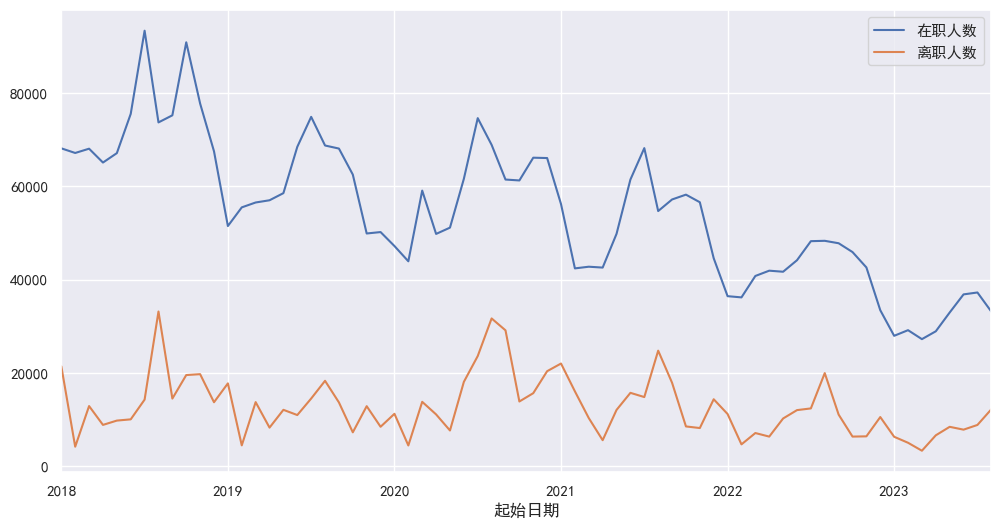

In [59]:
data["在职人数"].plot(x="起始日期",figsize=(12,6))
data["离职人数"].plot(x="起始日期",figsize=(12,6))

# data.set_index('起始日期', inplace=True)

# data["离职率"].plot(x="起始日期",figsize=(12,6))
plt.legend()
for i in range(0,90,12):
    plt.axvline(x=i,color = "red")

<Axes: xlabel='起始日期'>

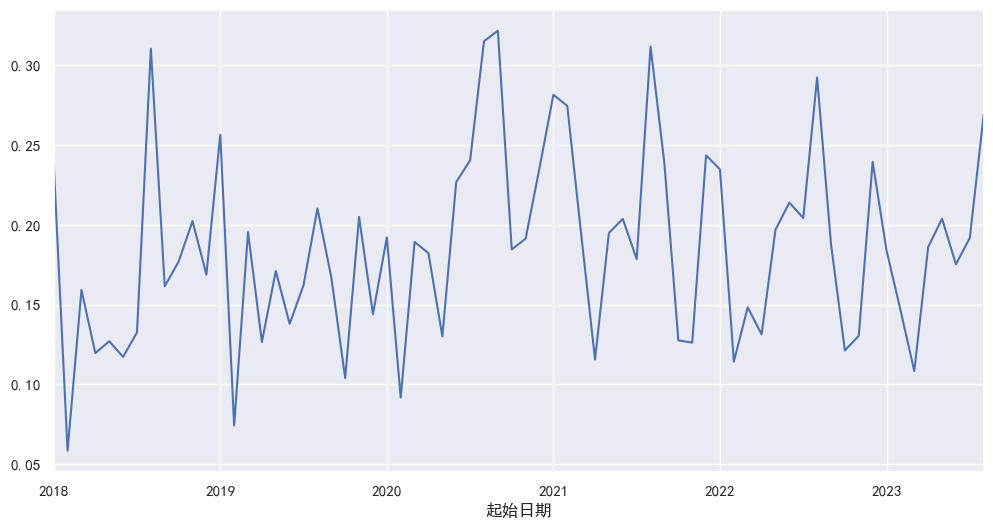

In [66]:
data["离职率"].plot(x="起始日期",figsize=(12,6))


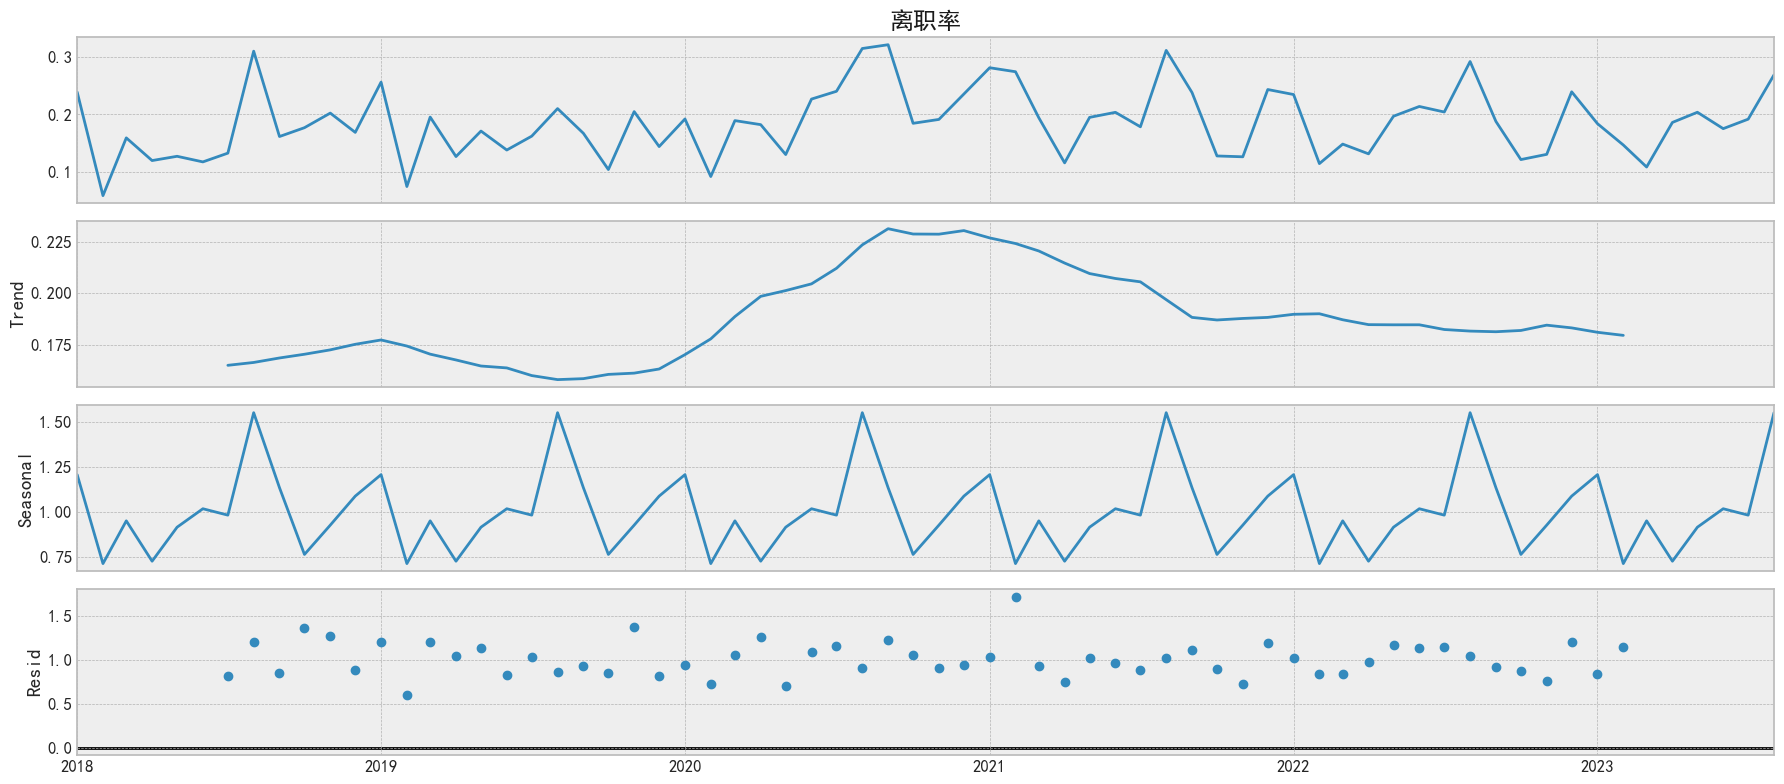

<Figure size 4000x1600 with 0 Axes>

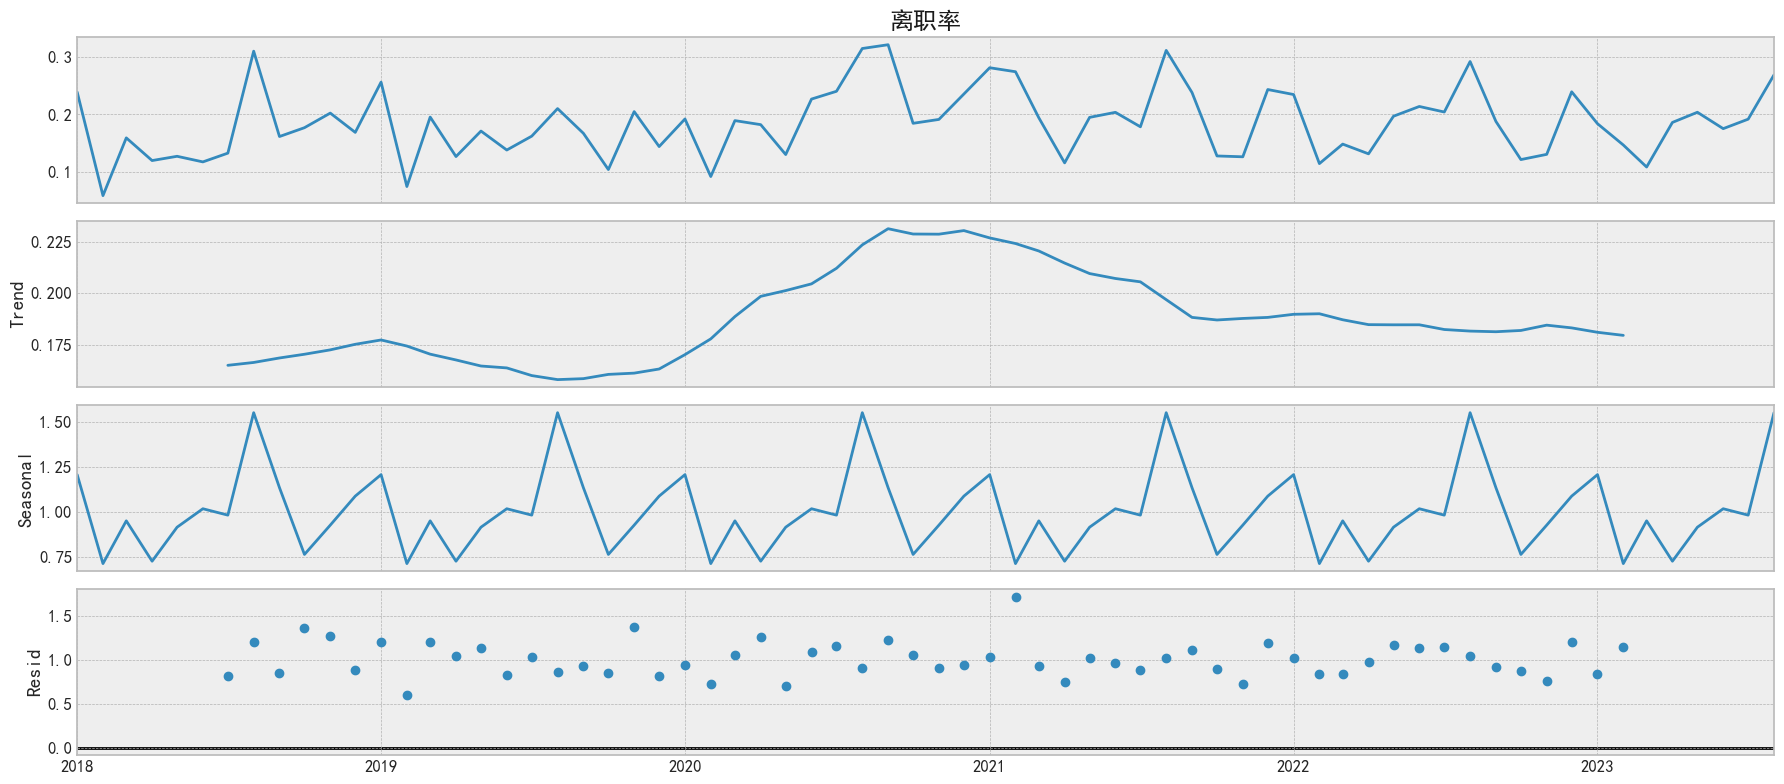

In [77]:
plt.rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = data['离职率']
result = seasonal_decompose(series, model='multiplicative')
result.plot()

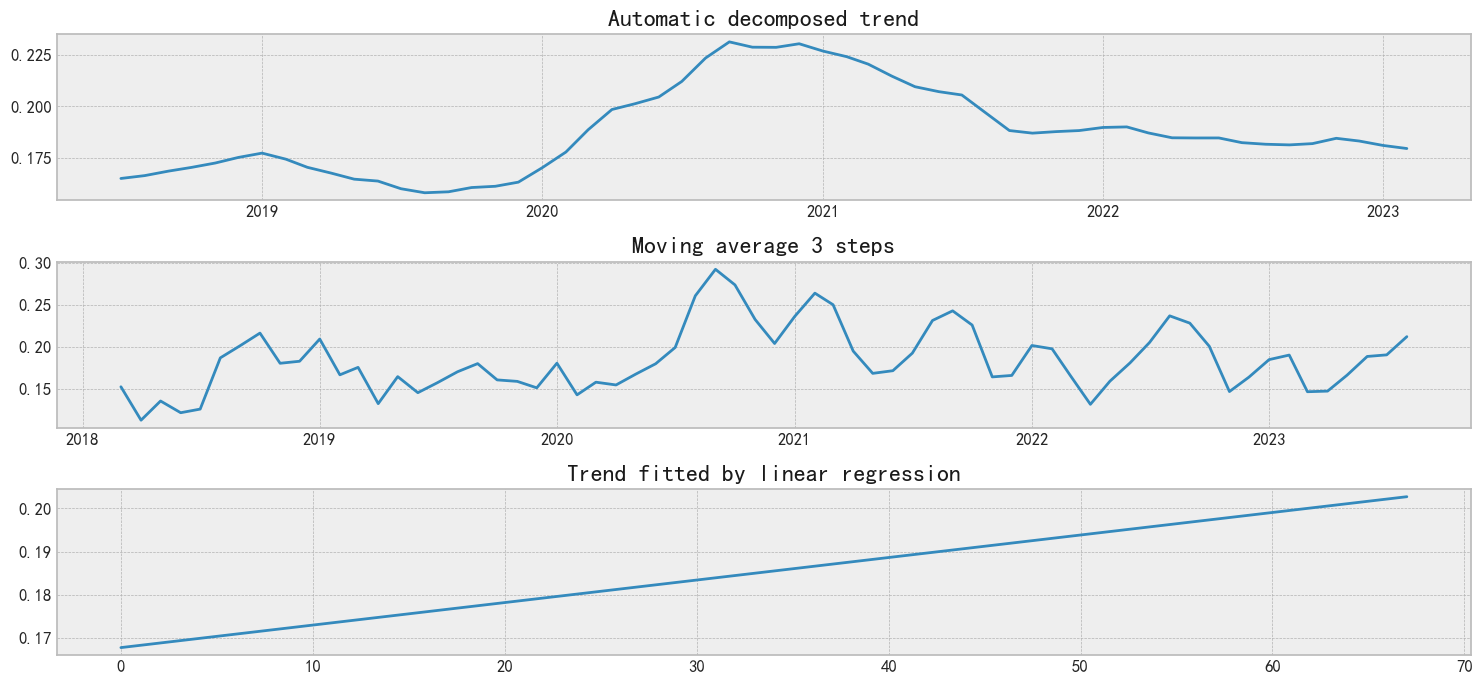

In [79]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = data["离职率"].rolling(3).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 3 steps")


X = [i for i in range(0, len(data["离职率"]))]
X = np.reshape(X, (len(X), 1))
y = data["离职率"].values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

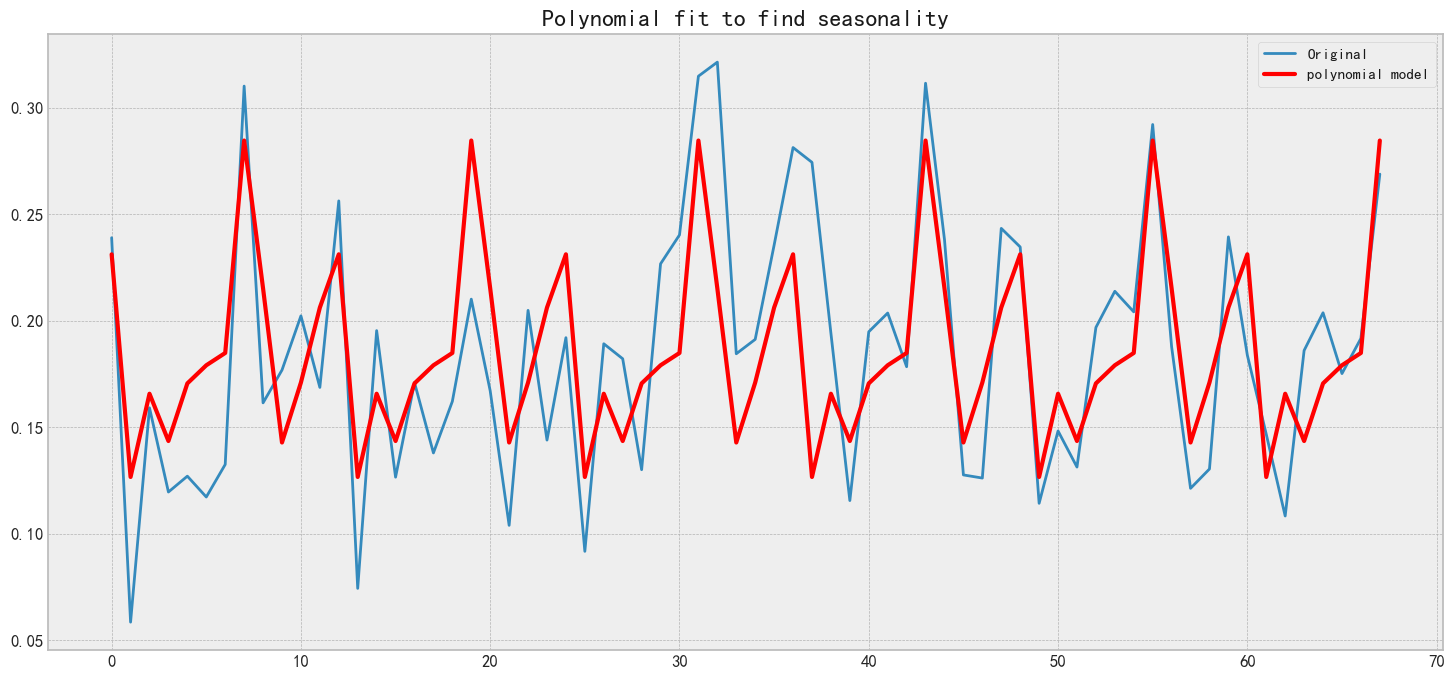

In [80]:
# Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = data["离职率"].values
X = [i % 12 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

## noise


Text(0.5, 1.0, 'Mean over time')

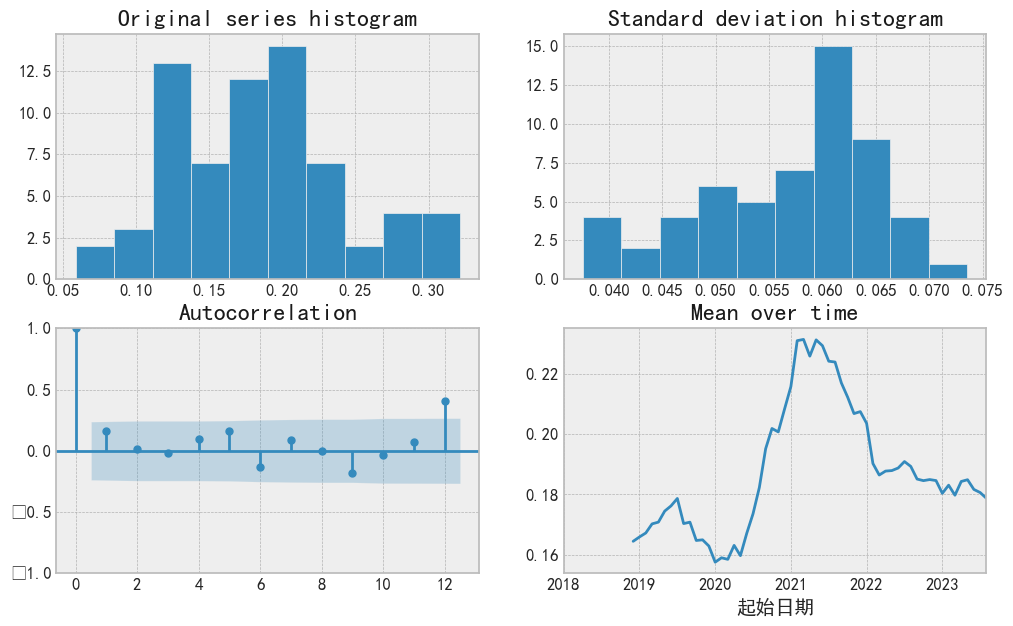

In [87]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

data["离职率"].hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=12, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = data["离职率"].rolling(12).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = data["离职率"].rolling(12).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")


## 平稳性检验

1. 离职率：\
ADF Statistic: -1.2803373386573695 \
n_lags: 0.6381193128758762 \ 
p-value: 0.6381193128758762 \
p值远远> 0.05，表示不拒绝原假设，即时间序列是不平稳的 \

2. 离职人数：\
ADF Statistic: -5.042372038142665 \ 
n_lags: 1.8284079305497475e-05  \
p-value: 1.8284079305497475e-05  \
p值远远< 0.05，表示拒绝原假设，即时间序列是平稳的


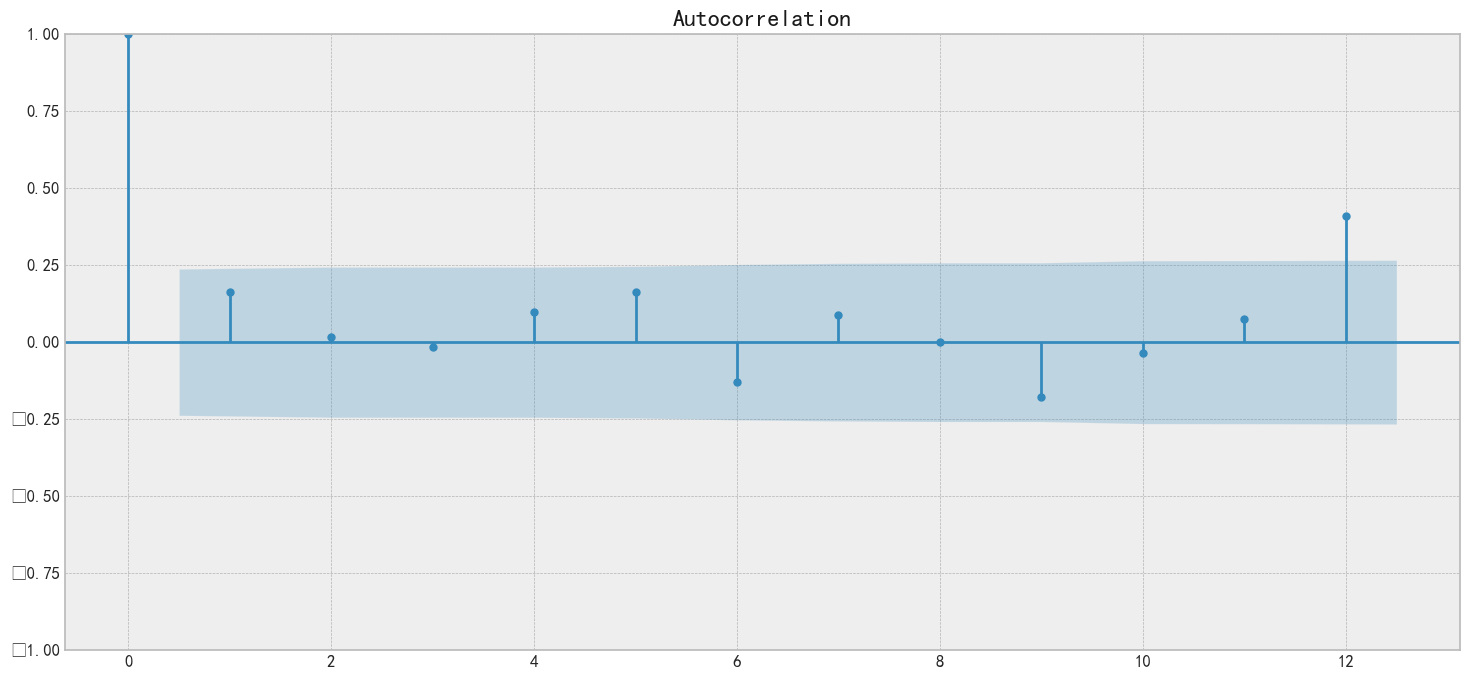

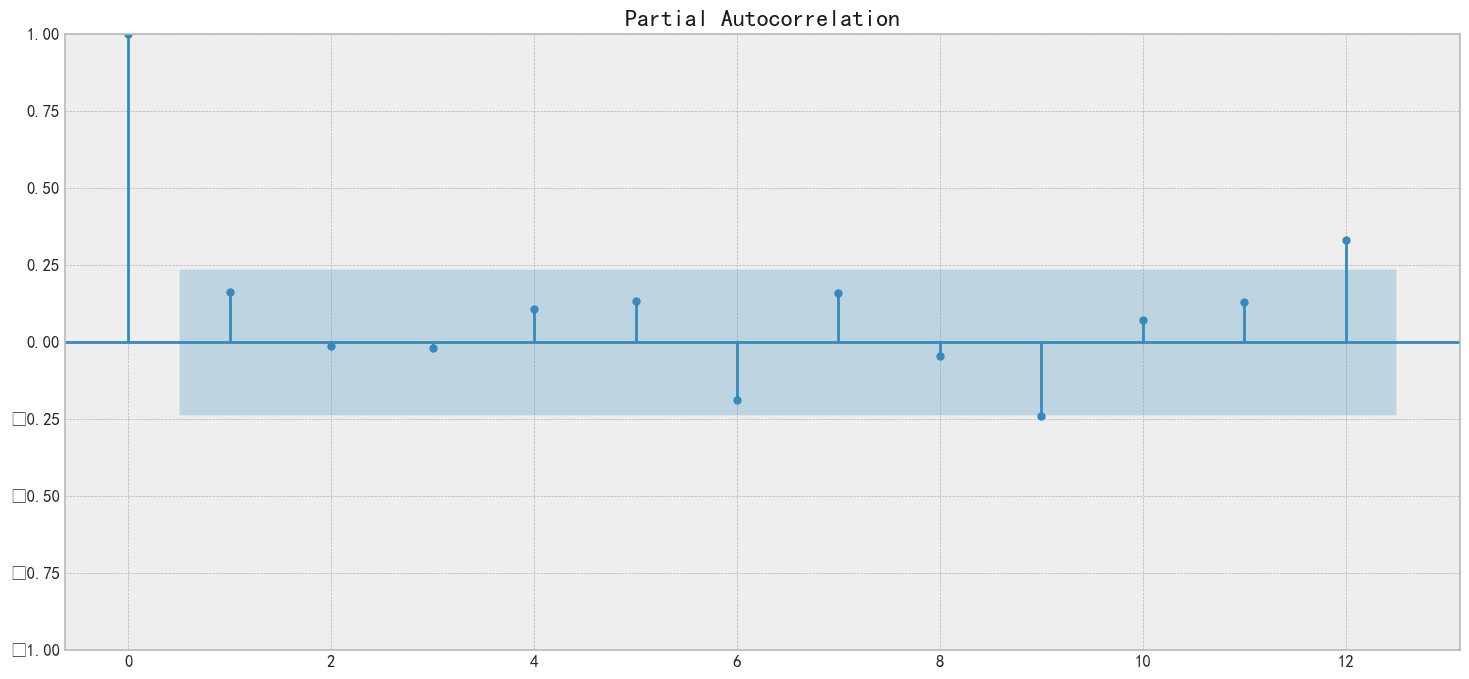

In [88]:
plot_acf(series, lags=12)
plot_pacf(series, lags=12)
plt.show()

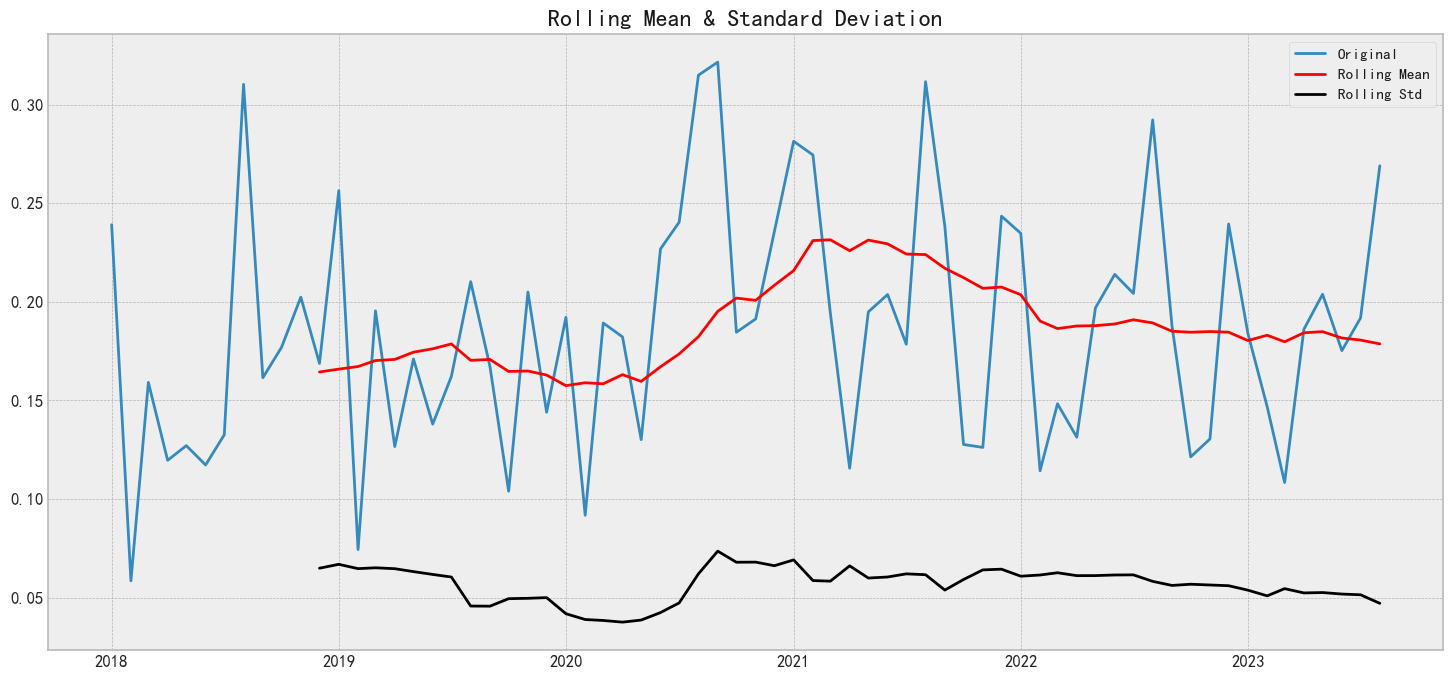

In [89]:
# Determing rolling statistics
rolmean = data["离职率"].rolling(window=12).mean()
rolstd = data["离职率"].rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(data["离职率"], label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

ADFuller检验的结果是一个统计量和一个p值。统计量用于判断时间序列数据是否具有单位根（即是否是非平稳的），p值用于判断检验结果的显著性。如果p值小于显著性水平，就可以拒绝原假设，即认为时间序列数据是平稳的；如果p值大于显著性水平，就不能拒绝原假设，即认为时间序列数据是非平稳的。通常情况下，显著性水平取0.05。

In [90]:
X = data["离职率"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
#  这里离职率不平稳

ADF Statistic: -1.280337
p-value: 0.638119
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595


## 差分

In [91]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset = diff
    return diff

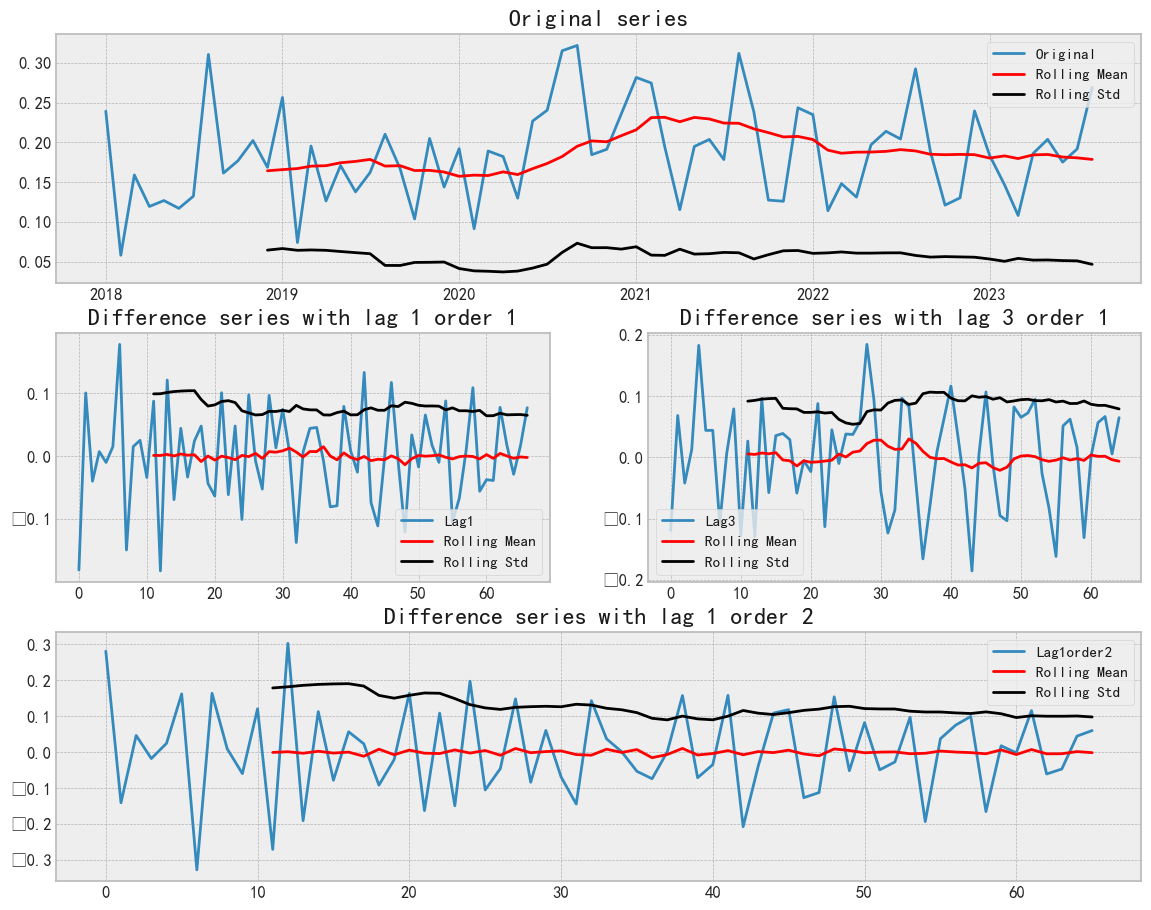

In [92]:
lag1series = pd.Series(difference(data["离职率"], interval=1, order=1))
lag3series = pd.Series(difference(data["离职率"], interval=3, order=1))
lag1order2series = pd.Series(difference(
    data["离职率"], interval=1, order=2))

fig = plt.figure(figsize=(14, 11))
layout = (3, 2)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag1 = plt.subplot2grid(layout, (1, 0))
lag3 = plt.subplot2grid(layout, (1, 1))
lag1order2 = plt.subplot2grid(layout, (2, 0), colspan=2)

original.set_title('Original series')
original.plot(data["离职率"], label='Original')
original.plot(data["离职率"].rolling(
    12).mean(), color='red', label='Rolling Mean')
original.plot(data["离职率"].rolling(12).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label="Lag1")
lag1.plot(lag1series.rolling(12).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(12).std(), color='black', label='Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label="Lag3")
lag3.plot(lag3series.rolling(12).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(12).std(), color='black', label='Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label="Lag1order2")
lag1order2.plot(lag1order2series.rolling(12).mean(),
                color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(12).std(),
                color='black', label='Rolling Std')
lag1order2.legend(loc='best')

## 对数变换


Text(0.5, 1.0, 'Log scale transformation into original series')

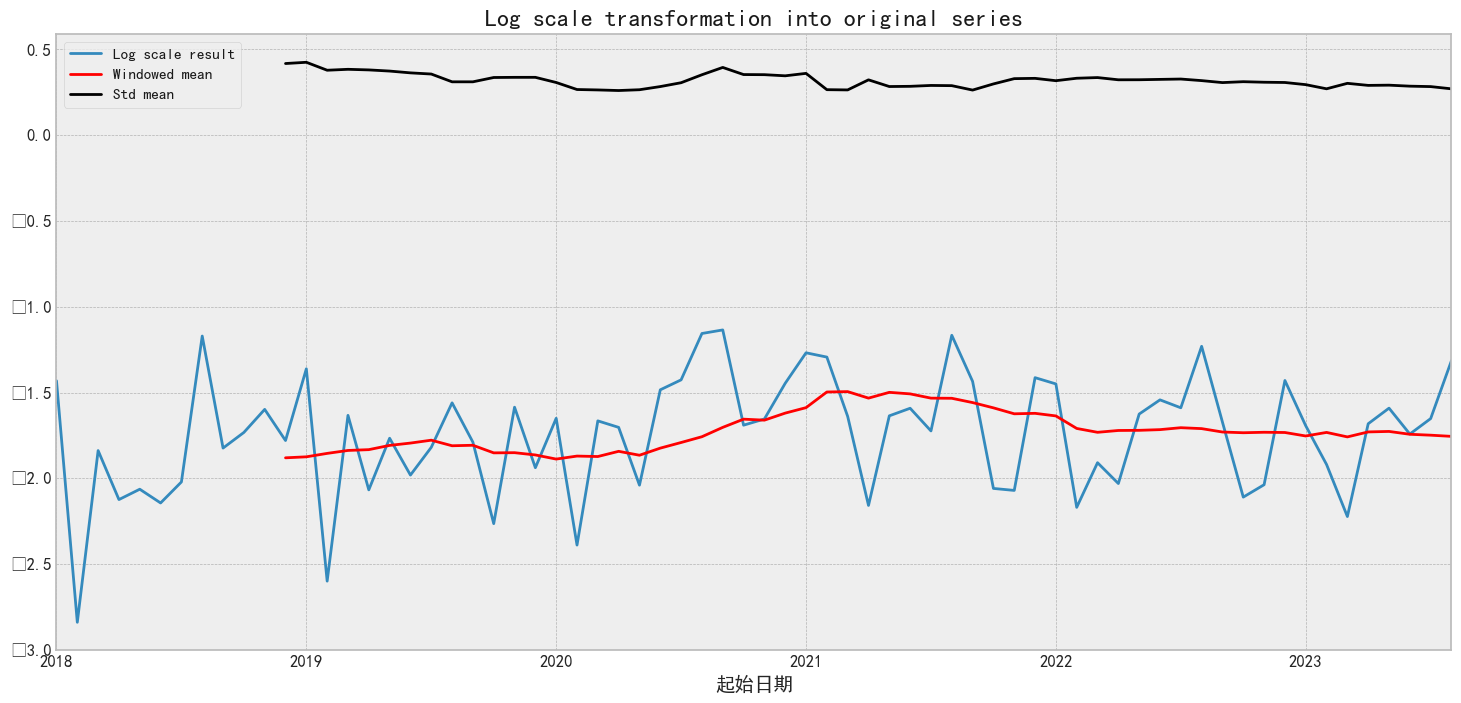

In [93]:
ts_log = np.log(data["离职率"])
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

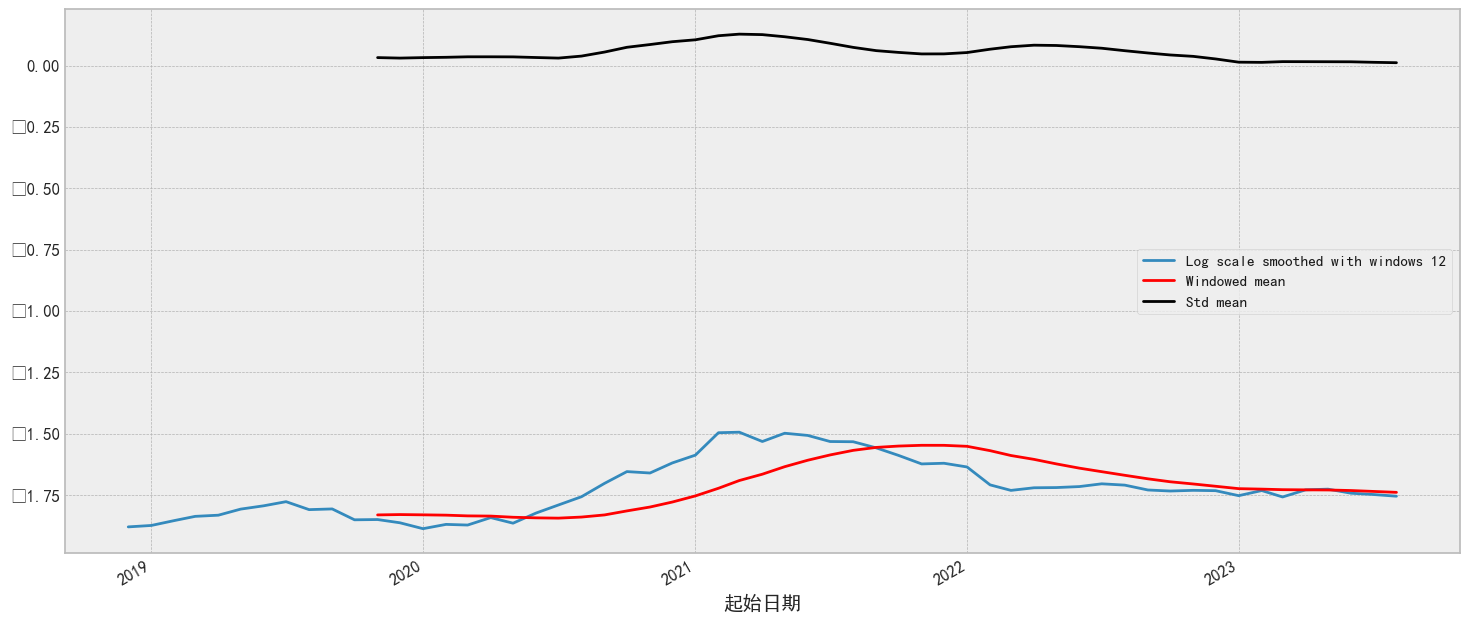

In [94]:
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()

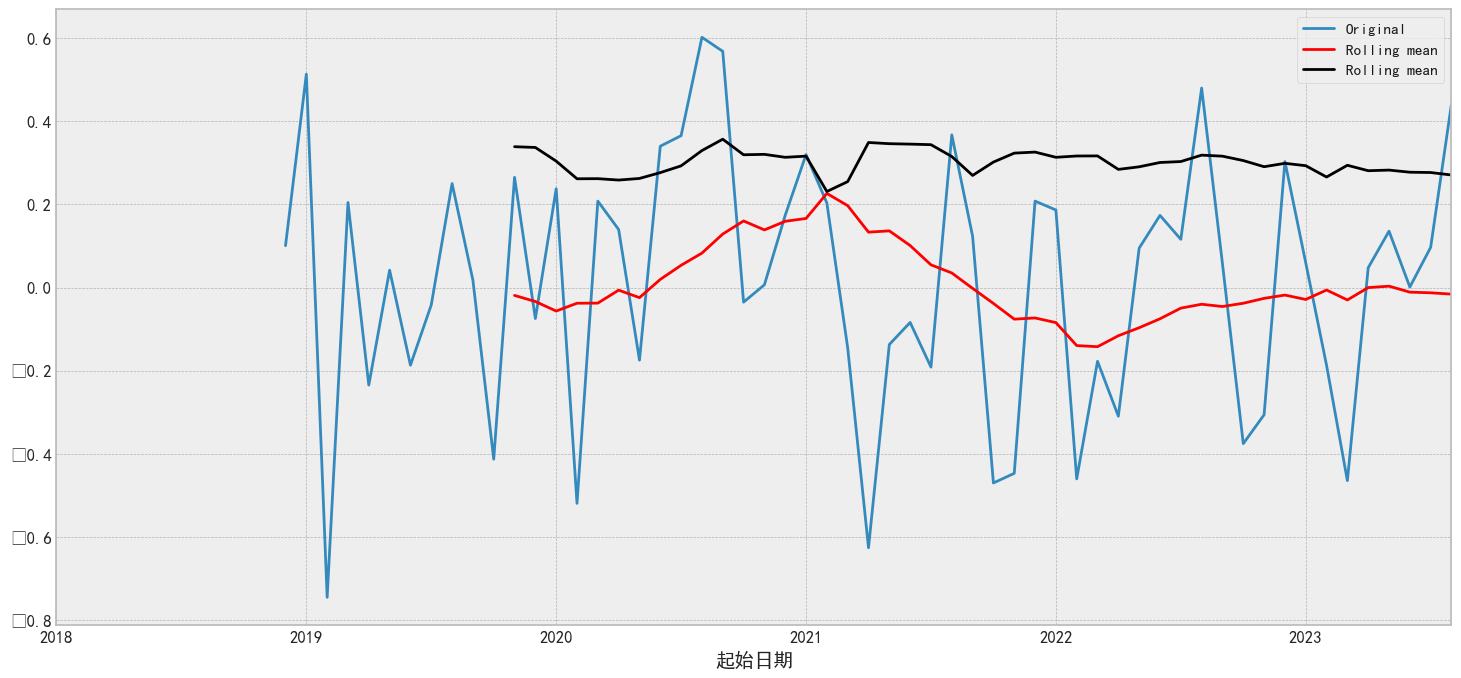

In [95]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(
    color='red', label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(
    color='black', label="Rolling mean")
plt.legend(loc='best')

## 寻找自相关

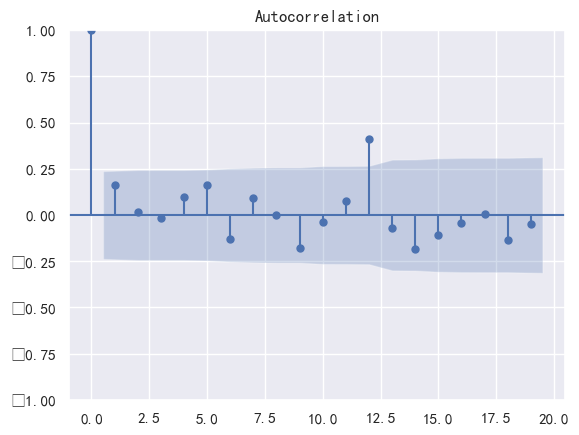

In [61]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# 画出acf函数
# 蓝色底色区域内画出的是95%置信区间，数据落在蓝色区域内表示在统计学意义上在x轴的时间间隔下具有自相关性
plot_acf(series)
plt.show()

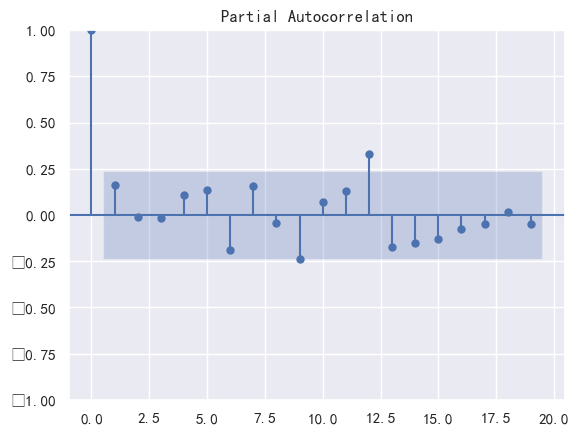

In [62]:
# 画出pacf函数
plot_pacf(series)
plt.show()

## 可视化

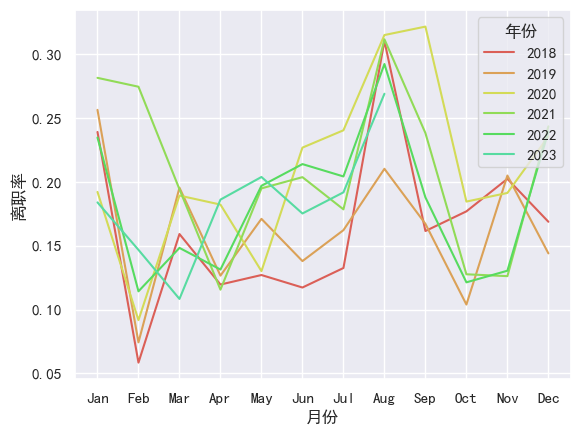

In [64]:
import seaborn as sns
palette = sns.color_palette('hls',12)
fig=sns.lineplot(x='月份',y='离职率',data=data,hue='年份',palette=palette)
fig.set_xticks(range(1,13))
fig.set_xticklabels(["Jan", "Feb", "Mar", "Apr","May", "Jun", "Jul", "Aug","Sep", "Oct", "Nov", "Dec"])
plt.show()

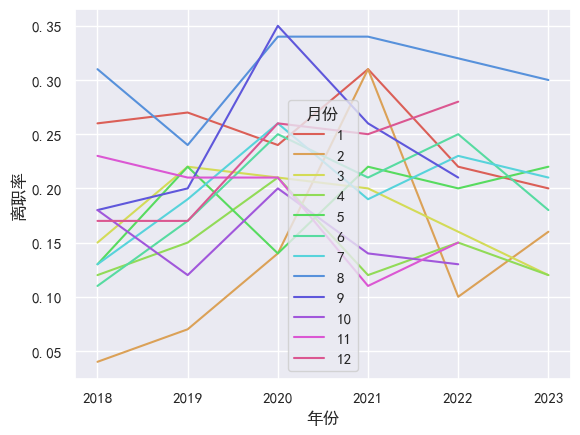

In [ ]:
fig=sns.lineplot(x='年份',y='离职率',data=a_data,hue='月份',palette=palette)
plt.show()

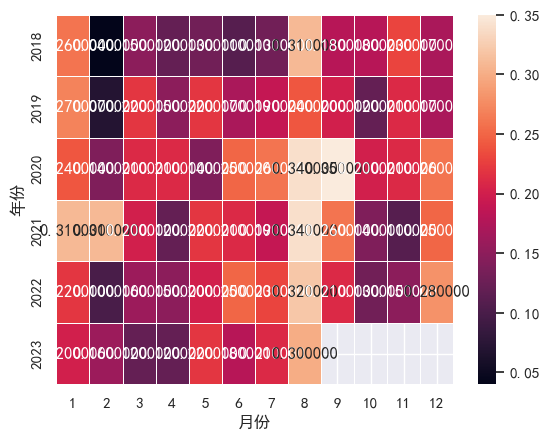

In [ ]:
data_mat= a_data.pivot(index='年份', columns='月份',values='离职率')
sns.heatmap(data=data_mat,annot=True,fmt='f',linewidths=0.5)
plt.show()

## 自回归模型AR
用AR模型的两个前提假定：
1. 过去发生的数据能够用来预测未来的数据（也就是数据之间是非独立的）
2. 时间序列数据时平稳的

<Axes: xlabel='起始日期'>

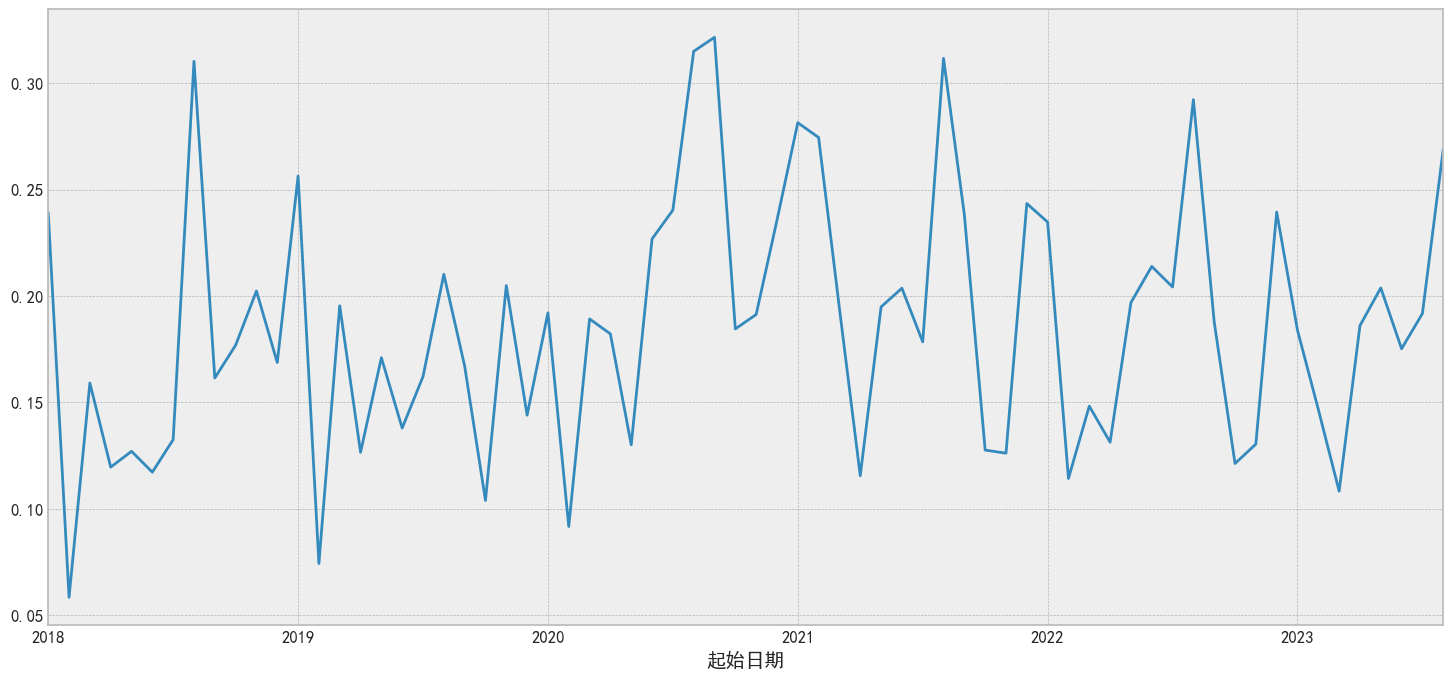

In [97]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
# data.set_index('起始日期', inplace=True)
data["离职率"].plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

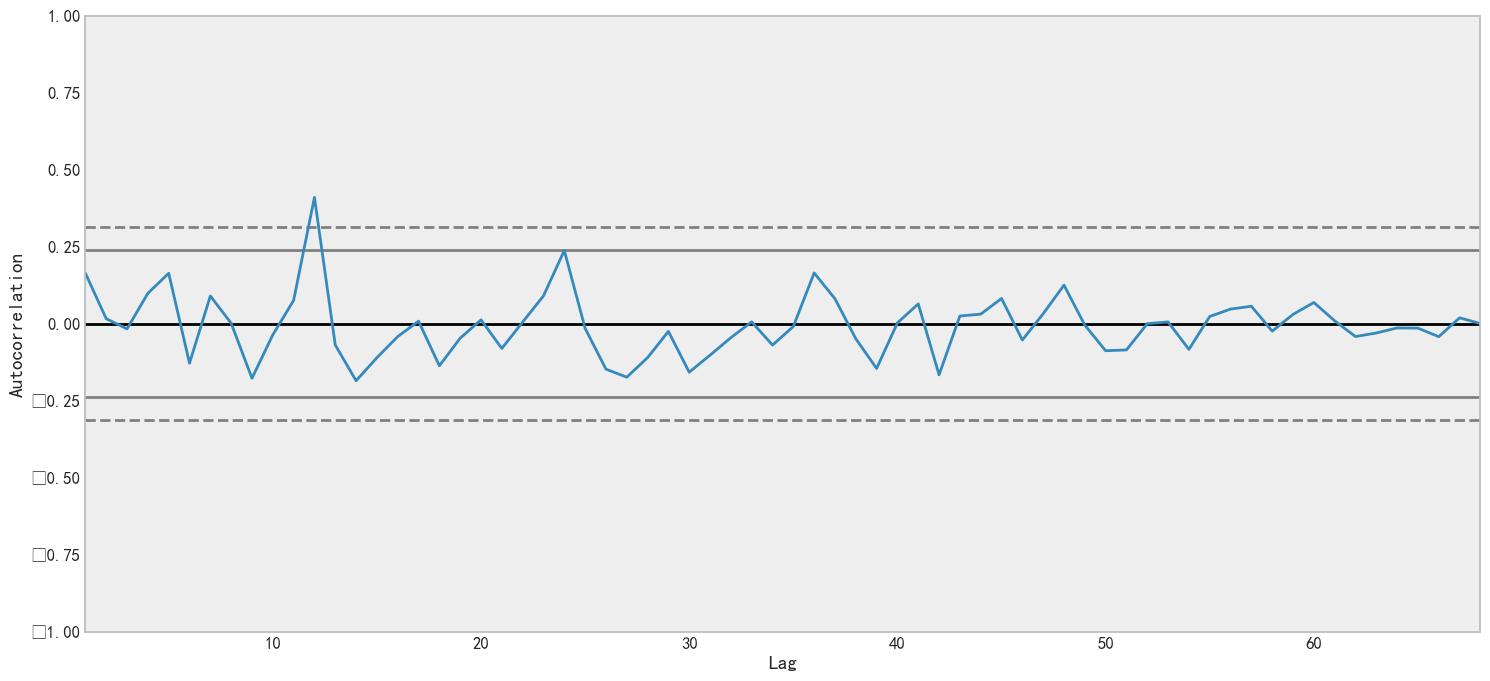

In [98]:
pd.plotting.autocorrelation_plot(data['离职率']) 
# 从自相关性图中发现没有表现出很强的相关性，只在前面一点时间表现出

<Axes: xlabel='y(t)', ylabel='y(t + 12)'>

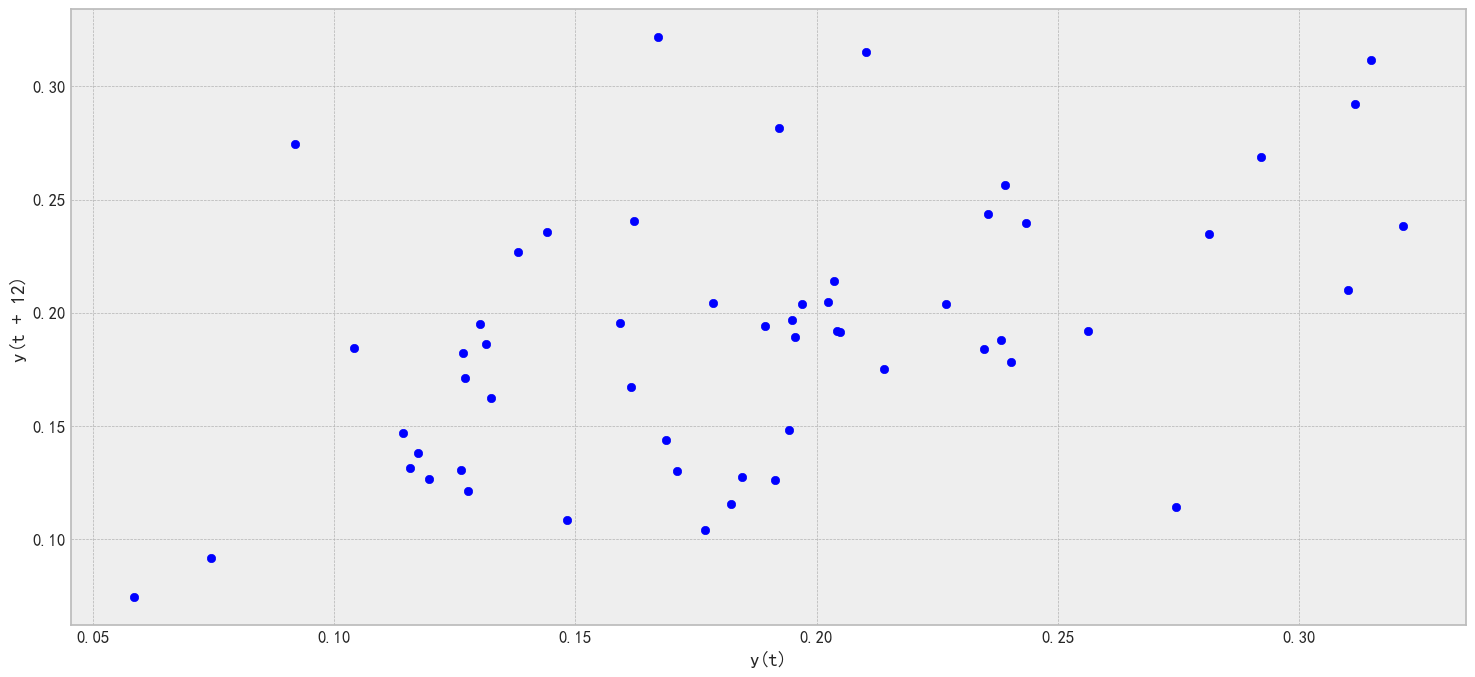

In [101]:
# 将上图中相关性最强的lag=12单独画散点图，观察相关性
pd.plotting.lag_plot(data['离职率'],lag=12)

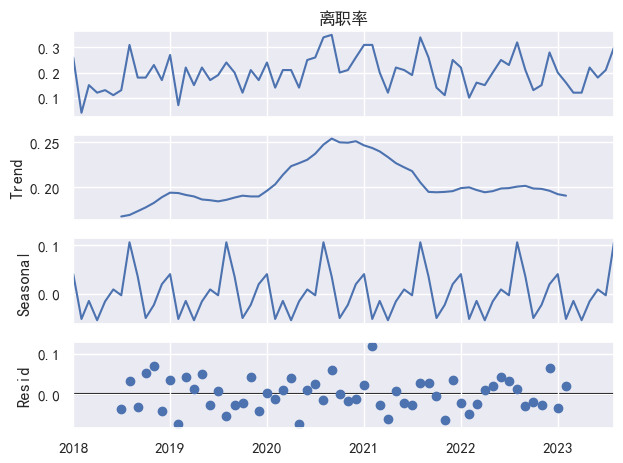

In [ ]:
# 数据集存在明显季节项（图三周期性变化）
decomposed = seasonal_decompose(data['离职率'], model='additive')
x = decomposed.plot()

In [109]:
# 划分训练集合测试集
X = data['离职率']
train_data = X[1:len(X)-3]
test_data = X[len(X)-3:]  #以最后十二个点作为待预测值

# 训练AR模型
model = AutoReg(train_data,lags=12,missing='drop',trend='t',seasonal=True) 
model_fitted = model.fit()

In [110]:
# 查看模型结果
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    离职率   No. Observations:                   64
Model:              Seas. AutoReg(12)   Log Likelihood                 103.597
Method:               Conditional MLE   S.D. of innovations              0.033
Date:                Wed, 22 Nov 2023   AIC                           -155.194
Time:                        10:42:15   BIC                           -104.461
Sample:                    02-01-2019   HQIC                          -135.744
                         - 05-01-2023                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.0005      0.000      1.376      0.169      -0.000       0.001
s(1,12)        0.0310      0.045      0.683      0.495      -0.058       0.120
s(2,12)        0.0858      0.045      1.894      0.058      -0.003       0.175
s(3,12)        0.0691      0.046      1.512      0.131      -0.020       0.159
s(4,12)        0.1124      0.046      2.435      0.015       0.022       0.203
s(5,12)        0.1222      0.049      2.501      0.012       0.026       0.218
s(6,12)        0.0838      0.051      1.637      0.102      -0.017       0.184
s(7,12)        0.1976      0.052      3.834      0.000       0.097       0.299
s(8,12)        0.1458      0.054      2.705      0.007       0.040       0.251
s(9,12)        0.0302      0.055      0.549      0.583      -0.078       0.138
s(10,12)       0.0344      0.055      0.629      0.529      -0.073       0.141
s(11,12)       0.0888      0.051      1.738      0.082      -0.011       0.189
s(12,12)       0.0728      0.049      1.494      0.135      -0.023       0.168
离职率.L1         0.1089      0.138      0.791      0.429      -0.161       0.379
离职率.L2         0.2126      0.138      1.539      0.124      -0.058       0.483
离职率.L3        -0.0365      0.141     -0.258      0.796      -0.313       0.240
离职率.L4         0.3174      0.125      2.534      0.011       0.072       0.563
离职率.L5         0.2291      0.130      1.765      0.078      -0.025       0.484
离职率.L6         0.0054      0.133      0.041      0.967      -0.255       0.265
离职率.L7        -0.0278      0.134     -0.208      0.835      -0.290       0.235
离职率.L8        -0.0738      0.126     -0.585      0.558      -0.321       0.174
离职率.L9        -0.4208      0.125     -3.369      0.001      -0.665      -0.176
离职率.L10        0.0315      0.135      0.232      0.816      -0.234       0.297
离职率.L11        0.1007      0.135      0.746      0.456      -0.164       0.365
离职率.L12       -0.0228      0.135     -0.168      0.866      -0.288       0.243
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0588           -0.2509j            1.0881           -0.0370
AR.2             1.0588           +0.2509j            1.0881            0.0370
AR.3             0.4569           -0.9657j            1.0683           -0.1797
AR.4             0.4569           +0.9657j            1.0683            0.1797
AR.5            -0.1510           -1.0928j            1.1032           -0.2719
AR.6            -0.1510           +1.0928j            1.1032            0.2719
AR.7            -0.8822           -0.7124j            1.1339           -0.3919
AR.8            -0.8822           +0.7124j            1.1339            0.3919
AR.9            -1.1188           -0.0000j            1.1188           -0.5000
AR

<Axes: >

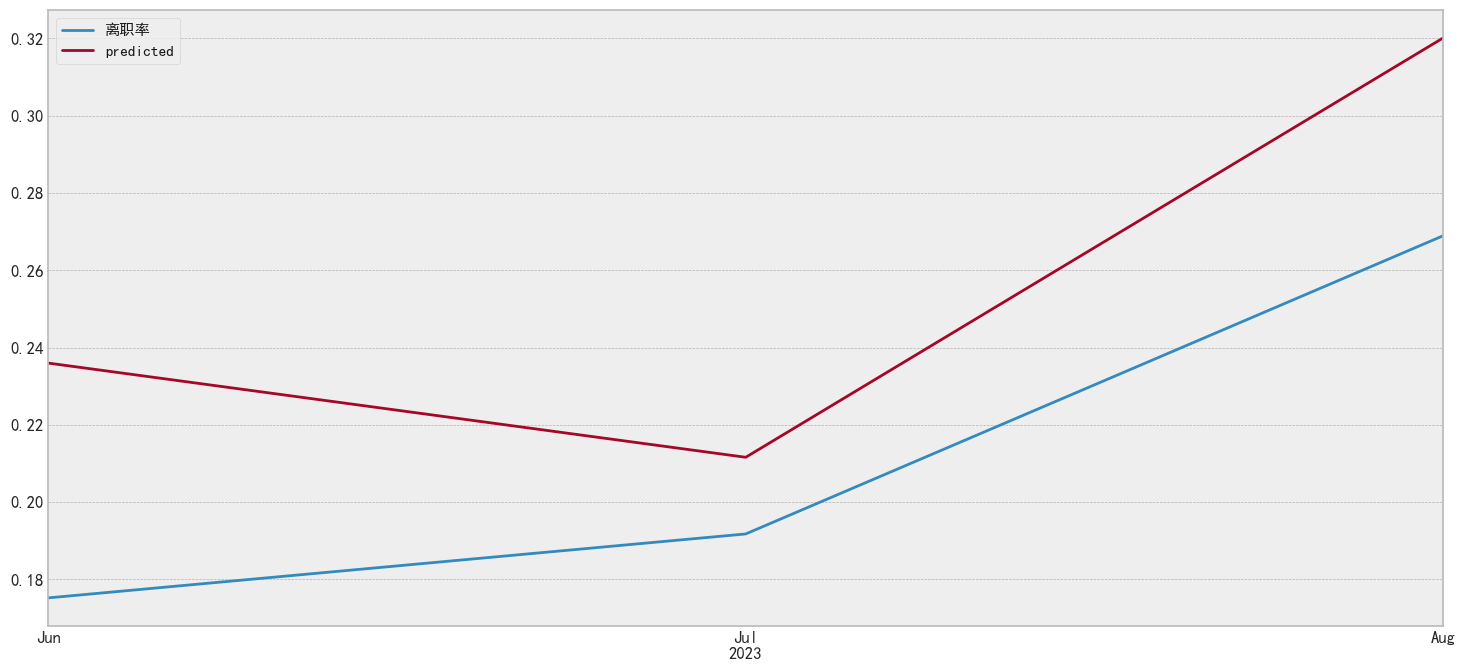

In [111]:
# 预测测试集
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)  # dynamic参数表示是否用预测值动态预测下一个时刻的值

# 比较真实值和预测值
compare_df = pd.concat(
    [data['离职率'].tail(3),
    predictions], axis=1).rename(
    columns={'sales': 'actual', 0:'predicted'})
compare_df.plot()

## ARIMA

In [112]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
# step2，检查平稳性
adf_test = ADFTest()
adf_test.should_diff(data["离职率"]) #结果表明平稳

(0.24480919741696522, True)

In [129]:
# step3，划分训练集和测试集

train = np.exp(data["离职率"][:-3])
test = np.exp(data["离职率"][-3:])


In [130]:
# step4，拟合模型
arima_model = auto_arima(train, start_p=0, d=1,start_q=0, max_p=5,max_d=5,max_q=5,
                         start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, seasonal=True,trace=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-105.547, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-118.671, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-129.581, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-121.891, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-127.631, Time=0.38 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-127.648, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-127.049, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-109.034, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-127.728, Time=0.23 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-127.744, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-121.478, Time=0.21 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-126.109, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-127.679, Time=0.33 sec

Best model:  ARIMA(0,1,

In [131]:
# 查看模型结果
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   65
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  67.791
Date:                            Wed, 22 Nov 2023   AIC                           -129.581
Time:                                    10:55:27   BIC                           -123.727
Sample:                                01-01-2018   HQIC                          -127.337
                                     - 05-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7223      0.097     -7.462      0.000      -0.912      -0.533
ma.S.L12      -0.5328      0.203     -2.620      0.009      -0.931      -0.134
sigma2         0.0039      0.001      4.711      0.000       0.002       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.70   Prob(JB):                         0.95
Heteroskedasticity (H):               0.72   Skew:                             0.11
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

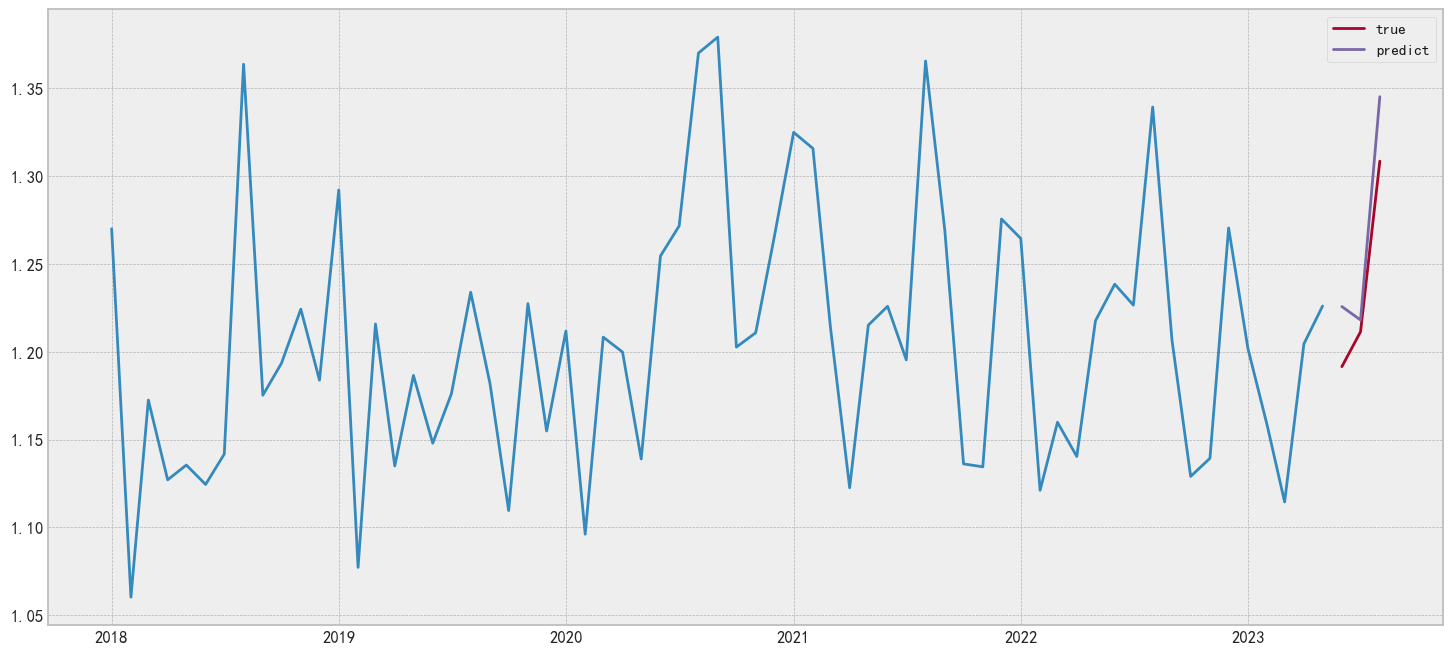

In [132]:
# step5，预测时间序列，并和真实值比较
pred = pd.DataFrame(arima_model.predict(n_periods=3),columns=['predicted'],index=test.index)
plt.plot(train)
plt.plot(test,label='true')
plt.plot(pred,label='predict')
plt.legend();

In [133]:
pre = np.log(pred)

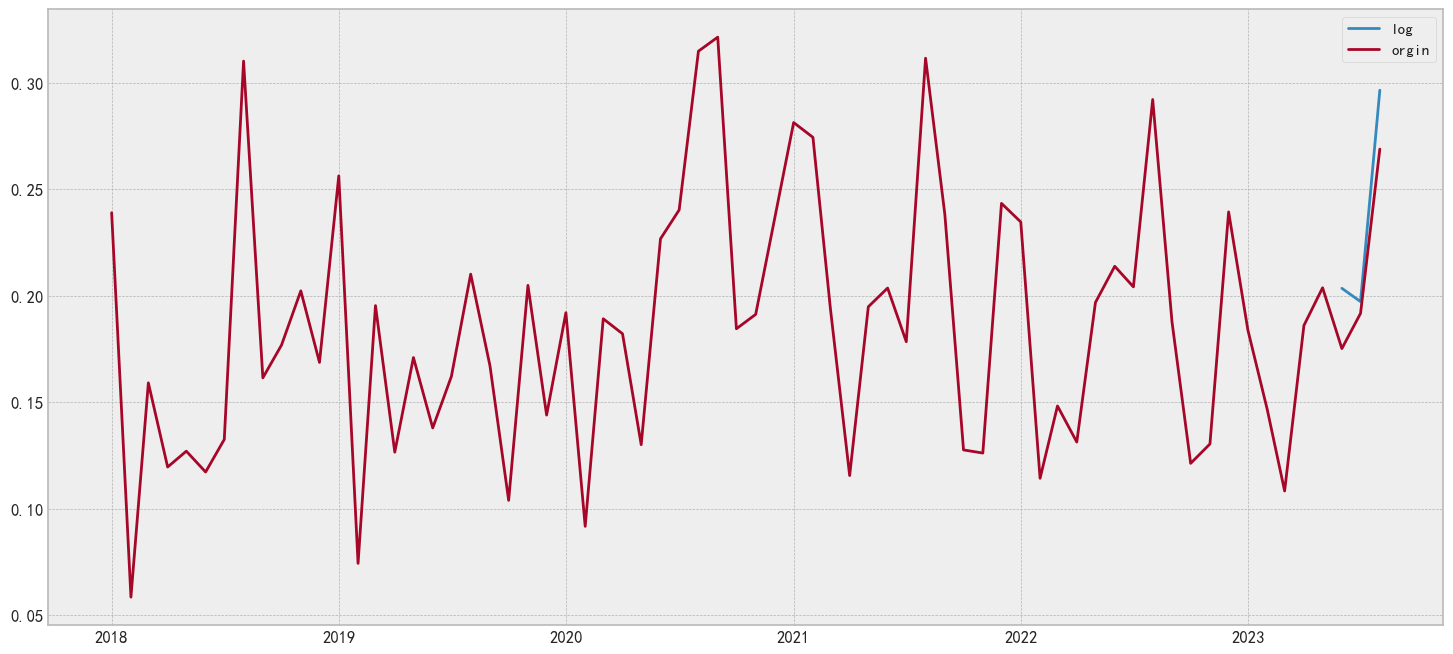

In [134]:
plt.plot(pre,label = 'log')
plt.plot(data["离职率"],label = "orgin")
plt.legend()
# plt.plot(pred,label='predict')

## 向量自回归模型

In [364]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
%matplotlib inline

In [365]:
df = data.copy()
df.head()

在职人数   离职人数
起始日期                    
2018-01-01  33768  12099
2018-02-01  33279   1502
2018-03-01  33261   6035
2018-04-01  32170   4302
2018-05-01  33790   5136

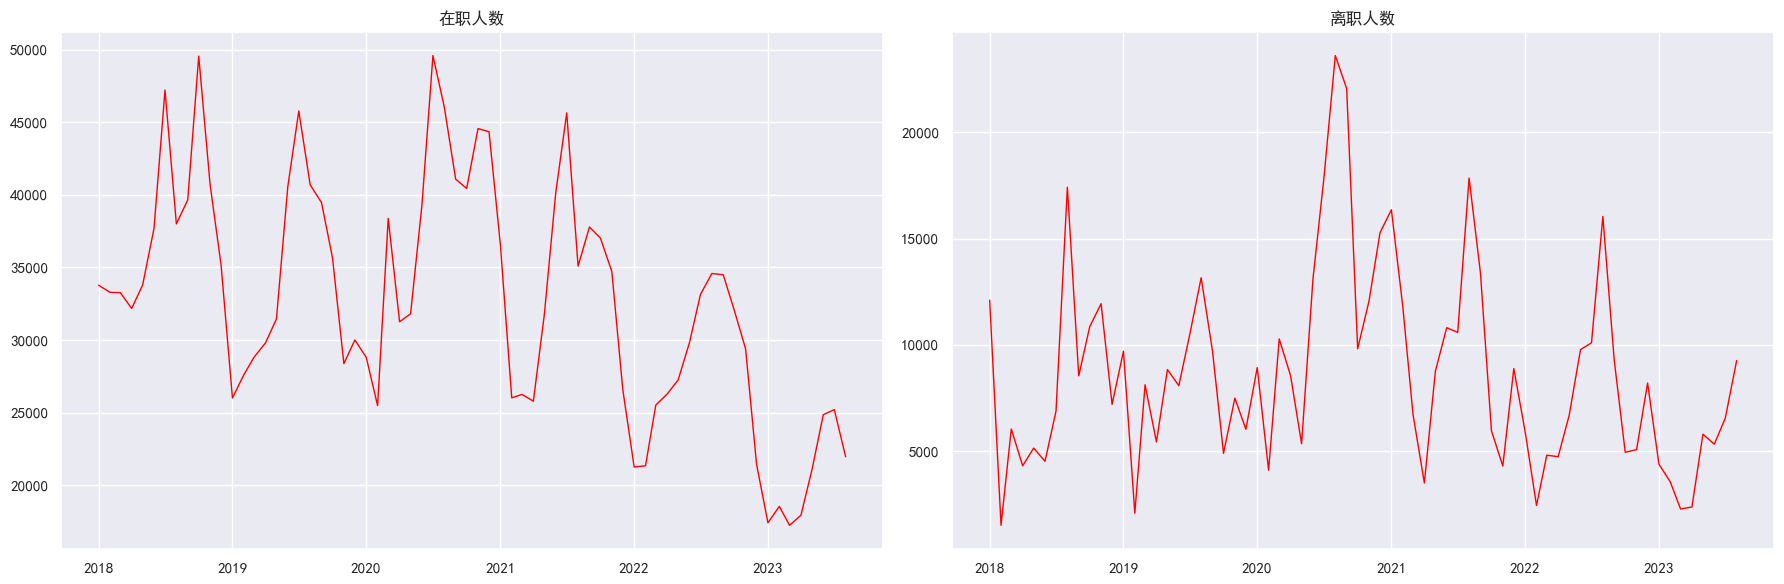

In [366]:
# 画出2个时间序列的图像
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(18,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
plt.tight_layout();

In [367]:
# step2：Granger’s Causality Test ， 检验不同序列之间存在互相影响
maxlag=12
test='ssr_chi2test'
variables=df.columns
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

在职人数_x  离职人数_x
在职人数_y     1.0     0.0
离职人数_y     0.0     1.0

In [368]:
# step3：ADF测试，检验单个变量是否平稳
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [369]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "在职人数" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0904
 No. Lags Chosen       = 1
 Critical value 1%     = -3.534
 Critical value 5%     = -2.906
 Critical value 10%    = -2.591
 => P-Value = 0.0273. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "离职人数" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4134
 No. Lags Chosen       = 0
 Critical value 1%     = -3.532
 Critical value 5%     = -2.906
 Critical value 10%    = -2.59
 => P-Value = 0.0003. Rejecting Null Hypothesis.
 => Series is Stationary.




In [370]:
# step4: 协整检验，检验多变量平稳性
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
在职人数   ::  9.64      > 12.3212   =>   False
离职人数   ::  1.47      > 4.1296    =>   False


In [371]:
# step5：划分训练集和测试集
nobs = 8  # 最后四个时间点作为测试集
df_train, df_test = df[0:-nobs], df[-nobs:]
# step7：选择模型阶数并训练，根据AIC值，lag=4时达到局部最优
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic, '\n')

Lag Order = 1
AIC :  33.541028364423276 

Lag Order = 2
AIC :  33.428540260025194 

Lag Order = 3
AIC :  33.55936881068319 

Lag Order = 4
AIC :  33.626136722220664 

Lag Order = 5
AIC :  33.63795551311591 

Lag Order = 6
AIC :  33.6799865907475 

Lag Order = 7
AIC :  33.62072129864687 

Lag Order = 8
AIC :  33.37355140558802 

Lag Order = 9
AIC :  33.38301347509312 



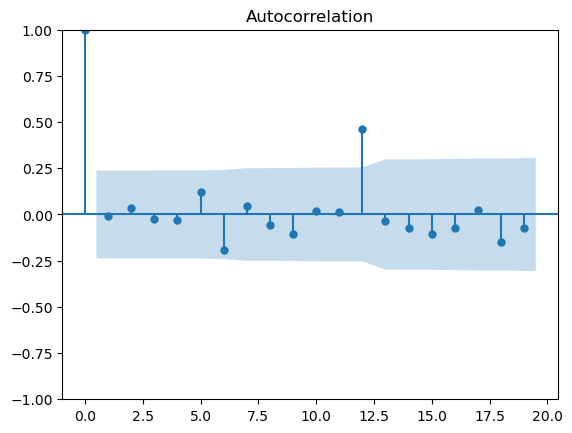

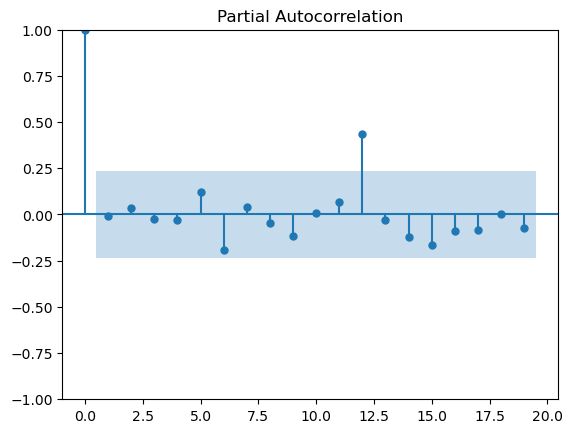

In [233]:
# step3，画出拟合残差的acf和pacf
plot_acf(res.resid)
plot_pacf(res.resid)
plt.show()

In [11]:
train_data = data[data["起始日期"] < "2023-01-01"]
val_data = data[data["起始日期"]>= "2023-01-01"]

In [12]:
val_data.shape

(8, 2)

## autods

In [197]:
model = AutoTS(
    forecast_length=12,
    frequency='infer',
    prediction_interval=0.95,
    ensemble='superensemble',
    holiday_country = 'CN'
)

model.fit(data,date_col = "起始日期", value_col='离职人数', id_col=None)

Data frequency is: MS, used frequency is: MS
Model Number: 1 with model ARIMA in generation 0 of 10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42737D+01    |proj g|=  5.59296D+00

At iterate    1    f=  1.40521D+01    |proj g|=  2.96327D+00

At iterate    2    f=  1.30058D+01    |proj g|=  1.99879D+00

At iterate    3    f=  1.20151D+01    |proj g|=  2.76651D+00

At iterate    4    f=  1.16954D+01    |proj g|=  1.84036D+00

At iterate    5    f=  1.13186D+01    |proj g|=  8.38972D-01

At iterate    6    f=  1.11868D+01    |proj g|=  9.75391D-01

At iterate    7    f=  1.11142D+01    |proj g|=  6.90891D-01

At iterate    8    f=  1.10644D+01    |proj g|=  6.00645D-01

At iterate    9    f=  1.09838D+01    |proj g|=  8.38422D-01

At iterate   10    f=  1.09470D+01    |proj g|=  4.11213D-01

At iterate   11    f=  1.09022D+01    |proj g|=  4

 This problem is unconstrained.



At iterate   14    f=  1.07992D+01    |proj g|=  4.65529D-01

At iterate   15    f=  1.07645D+01    |proj g|=  2.43079D-01

At iterate   16    f=  1.07006D+01    |proj g|=  3.41059D-01

At iterate   17    f=  1.06832D+01    |proj g|=  3.41570D-01

At iterate   18    f=  1.06741D+01    |proj g|=  1.39594D-01

At iterate   19    f=  1.06713D+01    |proj g|=  1.73465D-01

At iterate   20    f=  1.06680D+01    |proj g|=  2.67673D-01

At iterate   21    f=  1.06612D+01    |proj g|=  1.62192D-01

At iterate   22    f=  1.06498D+01    |proj g|=  3.51638D-01

At iterate   23    f=  1.06313D+01    |proj g|=  4.41040D-01

At iterate   24    f=  1.06241D+01    |proj g|=  3.98277D-01

At iterate   25    f=  1.06197D+01    |proj g|=  6.22542D-01

At iterate   26    f=  1.06126D+01    |proj g|=  2.68995D-01

At iterate   27    f=  1.06081D+01    |proj g|=  1.09233D-01

At iterate   28    f=  1.06037D+01    |proj g|=  1.74959D-01

At iterate   29    f=  1.05998D+01    |proj g|=  2.36908D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Model Number: 7 with model DatepartRegression in generation 0 of 10
Model Number: 8 with model DatepartRegression in generation 0 of 10
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 8 in generation 0: DatepartRegression
Model Number: 9 with model ETS in generation 0 of 10
Model Number: 10 with model ETS in generation 0 of 10
Model Number: 11 with model GLM in generation 0 of 10
Model Number: 12 with model GLM in generation 0 of 10
Model Number: 13 with model GLS in generation 0 of 10
Model Number: 14 with model GLS in generation 0 of 10
Model Number: 15 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 15 in generation 0: GluonTS
Model Number: 16 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The

 This problem is unconstrained.



At iterate   32    f= -2.12081D-01    |proj g|=  5.85925D-03

At iterate   33    f= -2.12088D-01    |proj g|=  7.71154D-03

At iterate   34    f= -2.12105D-01    |proj g|=  1.05567D-02

At iterate   35    f= -2.12137D-01    |proj g|=  1.97652D-02

At iterate   36    f= -2.12157D-01    |proj g|=  1.32583D-02

At iterate   37    f= -2.12167D-01    |proj g|=  9.42331D-03

At iterate   38    f= -2.12176D-01    |proj g|=  4.52363D-03

At iterate   39    f= -2.12185D-01    |proj g|=  5.57605D-03

At iterate   40    f= -2.12193D-01    |proj g|=  2.22018D-03

At iterate   41    f= -2.12199D-01    |proj g|=  2.76893D-03

At iterate   42    f= -2.12213D-01    |proj g|=  1.80271D-02

At iterate   43    f= -2.12225D-01    |proj g|=  1.08183D-02

At iterate   44    f= -2.12228D-01    |proj g|=  8.34727D-03

At iterate   45    f= -2.12233D-01    |proj g|=  8.13182D-03

At iterate   46    f= -2.12240D-01    |proj g|=  5.14448D-03

At iterate   47    f= -2.12248D-01    |proj g|=  8.47424D-03

At iter

 This problem is unconstrained.


Model Number: 284 with model ETS in generation 1 of 10
Model Number: 285 with model UnobservedComponents in generation 1 of 10
Model Number: 286 with model GLM in generation 1 of 10
Model Number: 287 with model GLM in generation 1 of 10
Model Number: 288 with model SectionalMotif in generation 1 of 10
Model Number: 289 with model MultivariateMotif in generation 1 of 10
Model Number: 290 with model WindowRegression in generation 1 of 10
Model Number: 291 with model UnobservedComponents in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 291 in generation 1: UnobservedComponents
Model Number: 292 with model ETS in generation 1 of 10
Model Number: 293 with model UnobservedComponents in generation 1 of 10
Model Number: 294 with model AverageValueNaive in generation 1 of 10
Model Number: 295 with model UnobservedComponents in generation 1 of 10
Model Number: 296 with model AverageValueNaive in generation 1 of 10
Model Num

 This problem is unconstrained.



At iterate    4    f= -1.16589D+00    |proj g|=  8.95562D-01

At iterate    5    f= -1.22950D+00    |proj g|=  2.80762D+00

At iterate    6    f= -1.26123D+00    |proj g|=  6.69382D-01

At iterate    7    f= -1.26473D+00    |proj g|=  2.31481D-01

At iterate    8    f= -1.26718D+00    |proj g|=  2.18393D-01

At iterate    9    f= -1.29429D+00    |proj g|=  1.77808D+00

At iterate   10    f= -1.32405D+00    |proj g|=  2.33272D+00

At iterate   11    f= -1.34450D+00    |proj g|=  1.31300D+00

At iterate   12    f= -1.35062D+00    |proj g|=  2.81225D-01

At iterate   13    f= -1.35926D+00    |proj g|=  2.10758D+00

At iterate   14    f= -1.36407D+00    |proj g|=  2.12585D+00

At iterate   15    f= -1.41208D+00    |proj g|=  1.80421D+00

At iterate   16    f= -1.42078D+00    |proj g|=  2.52629D+00

At iterate   17    f= -1.43706D+00    |proj g|=  8.52046D-01

At iterate   18    f= -1.44051D+00    |proj g|=  7.05361D-01

At iterate   19    f= -1.45434D+00    |proj g|=  2.49300D-01

At iter

 This problem is unconstrained.



At iterate   24    f=  1.00121D+01    |proj g|=  1.30863D-01

At iterate   25    f=  1.00101D+01    |proj g|=  4.18351D-02

At iterate   26    f=  1.00092D+01    |proj g|=  4.71261D-02

At iterate   27    f=  1.00085D+01    |proj g|=  4.53262D-02

At iterate   28    f=  1.00077D+01    |proj g|=  5.71473D-02

At iterate   29    f=  1.00068D+01    |proj g|=  3.68824D-02

At iterate   30    f=  1.00057D+01    |proj g|=  3.72466D-02

At iterate   31    f=  1.00054D+01    |proj g|=  2.82228D-02

At iterate   32    f=  1.00051D+01    |proj g|=  8.62455D-03

At iterate   33    f=  1.00050D+01    |proj g|=  7.48639D-03

At iterate   34    f=  1.00049D+01    |proj g|=  4.08870D-03

At iterate   35    f=  1.00049D+01    |proj g|=  3.40076D-03

At iterate   36    f=  1.00049D+01    |proj g|=  9.48021D-03

At iterate   37    f=  1.00049D+01    |proj g|=  6.70818D-03

At iterate   38    f=  1.00049D+01    |proj g|=  3.86547D-03

At iterate   39    f=  1.00048D+01    |proj g|=  7.69293D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


At iterate  230    f=  9.88622D+00    |proj g|=  3.12838D-02

At iterate  231    f=  9.88610D+00    |proj g|=  1.14140D-02

At iterate  232    f=  9.88605D+00    |proj g|=  1.30292D-02

At iterate  233    f=  9.88601D+00    |proj g|=  6.51983D-03

At iterate  234    f=  9.88595D+00    |proj g|=  1.09854D-02

At iterate  235    f=  9.88589D+00    |proj g|=  1.81369D-02

At iterate  236    f=  9.88580D+00    |proj g|=  1.03597D-02

At iterate  237    f=  9.88577D+00    |proj g|=  9.91661D-03

At iterate  238    f=  9.88577D+00    |proj g|=  1.70475D-02

At iterate  239    f=  9.88576D+00    |proj g|=  2.90881D-03

At iterate  240    f=  9.88575D+00    |proj g|=  4.61254D-03

At iterate  241    f=  9.88574D+00    |proj g|=  1.19792D-02

At iterate  242    f=  9.88572D+00    |proj g|=  2.40128D-02

At iterate  243    f=  9.88566D+00    |proj g|=  3.91064D-02

At iterate  244    f=  9.88556D+00    |proj g|=  5.30934D-02

At iterate  245    f=  9.88539D+00    |proj g|=  5.46044D-02

At itera

 This problem is unconstrained.


Model Number: 388 with model MetricMotif in generation 2 of 10
Model Number: 389 with model LastValueNaive in generation 2 of 10
Model Number: 390 with model MultivariateMotif in generation 2 of 10
Model Number: 391 with model SeasonalNaive in generation 2 of 10
Model Number: 392 with model MetricMotif in generation 2 of 10
Template Eval Error: Exception('Transformer KalmanSmoothing failed on fit') in model 392 in generation 2: MetricMotif
Model Number: 393 with model GLS in generation 2 of 10
Model Number: 394 with model AverageValueNaive in generation 2 of 10
Model Number: 395 with model DatepartRegression in generation 2 of 10
Model Number: 396 with model ETS in generation 2 of 10
Model Number: 397 with model UnobservedComponents in generation 2 of 10
Model Number: 398 with model UnivariateMotif in generation 2 of 10
Model Number: 399 with model ARDL in generation 2 of 10
Model Number: 400 with model AverageValueNaive in generation 2 of 10
Model Number: 401 with model UnobservedComp

 This problem is unconstrained.


Model Number: 484 with model UnivariateMotif in generation 3 of 10
Template Eval Error: ValueError('kth(=20) out of bounds (17)') in model 484 in generation 3: UnivariateMotif
Model Number: 485 with model SeasonalNaive in generation 3 of 10
Model Number: 486 with model ARDL in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 486 in generation 3: ARDL
Model Number: 487 with model WindowRegression in generation 3 of 10
Model Number: 488 with model GLM in generation 3 of 10
Model Number: 489 with model LastValueNaive in generation 3 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 489 in generation 3: LastValueNaive
Model Number: 490 with model ARDL in generation 3 of 10
Model Number: 491 with model UnivariateRegression in generation 3 of 10
Model Number: 492 with model SeasonalNaive in generation 3 of 10
Model Number: 493 with model Theta in generation 3 of 10
RUNNING THE L-BFGS

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Model Number: 495 with model DatepartRegression in generation 3 of 10
Model Number: 496 with model Theta in generation 3 of 10
Model Number: 497 with model ETS in generation 3 of 10
Model Number: 498 with model WindowRegression in generation 3 of 10
Model Number: 499 with model ARDL in generation 3 of 10
Model Number: 500 with model ETS in generation 3 of 10
Model Number: 501 with model GLM in generation 3 of 10
Model Number: 502 with model GLM in generation 3 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 502 in generation 3: GLM
Model Number: 503 with model UnobservedComponents in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 503 in generation 3: UnobservedComponents
Model Number: 504 with model LastValueNaive in generation 3 of 10
Model Number: 505 with model MetricMotif in generation 3 of 10
M

 This problem is unconstrained.



At iterate   10    f=  1.09043D+01    |proj g|=  4.95687D-01

At iterate   11    f=  1.08923D+01    |proj g|=  1.17278D+00

At iterate   12    f=  1.08499D+01    |proj g|=  3.30111D-01

At iterate   13    f=  1.08328D+01    |proj g|=  3.56256D-01

At iterate   14    f=  1.08206D+01    |proj g|=  3.03087D-01

At iterate   15    f=  1.08163D+01    |proj g|=  1.49919D-01

At iterate   16    f=  1.08042D+01    |proj g|=  2.23764D-01

At iterate   17    f=  1.07971D+01    |proj g|=  2.52104D-01

At iterate   18    f=  1.07746D+01    |proj g|=  2.81152D-01

At iterate   19    f=  1.07493D+01    |proj g|=  3.07688D-01

At iterate   20    f=  1.07414D+01    |proj g|=  6.93720D-01

At iterate   21    f=  1.07024D+01    |proj g|=  2.84410D-01

At iterate   22    f=  1.06898D+01    |proj g|=  1.75949D-01

At iterate   23    f=  1.06746D+01    |proj g|=  2.53386D-01

At iterate   24    f=  1.06566D+01    |proj g|=  4.48753D-01

At iterate   25    f=  1.06337D+01    |proj g|=  3.81973D-01

At iter

 This problem is unconstrained.



At iterate   32    f=  1.00281D+01    |proj g|=  1.82650D-01

At iterate   33    f=  9.97147D+00    |proj g|=  4.35459D-01

At iterate   34    f=  9.89998D+00    |proj g|=  2.12845D-01

At iterate   35    f=  9.89238D+00    |proj g|=  7.24048D-02

At iterate   36    f=  9.89142D+00    |proj g|=  5.01349D-02

At iterate   37    f=  9.89061D+00    |proj g|=  2.83710D-02

At iterate   38    f=  9.89044D+00    |proj g|=  1.60760D-02

At iterate   39    f=  9.89023D+00    |proj g|=  2.66481D-02

At iterate   40    f=  9.88959D+00    |proj g|=  7.67136D-02

At iterate   41    f=  9.88840D+00    |proj g|=  1.37360D-01

At iterate   42    f=  9.88652D+00    |proj g|=  1.84949D-01

At iterate   43    f=  9.88465D+00    |proj g|=  1.32464D-01

At iterate   44    f=  9.88380D+00    |proj g|=  1.21274D-02

At iterate   45    f=  9.88379D+00    |proj g|=  1.56490D-03

At iterate   46    f=  9.88379D+00    |proj g|=  1.33024D-03

At iterate   47    f=  9.88379D+00    |proj g|=  1.23266D-03

At iter

 This problem is unconstrained.


Model Number: 705 with model AverageValueNaive in generation 5 of 10
Model Number: 706 with model NVAR in generation 5 of 10
Model Number: 707 with model AverageValueNaive in generation 5 of 10
Model Number: 708 with model GLS in generation 5 of 10
Model Number: 709 with model ARDL in generation 5 of 10
Model Number: 710 with model NVAR in generation 5 of 10
Model Number: 711 with model ETS in generation 5 of 10
Model Number: 712 with model ETS in generation 5 of 10
Model Number: 713 with model SeasonalNaive in generation 5 of 10
Model Number: 714 with model UnobservedComponents in generation 5 of 10
Model Number: 715 with model AverageValueNaive in generation 5 of 10
Model Number: 716 with model UnivariateMotif in generation 5 of 10
Model Number: 717 with model Theta in generation 5 of 10
Model Number: 718 with model Theta in generation 5 of 10
Model Number: 719 with model MultivariateMotif in generation 5 of 10
Template Eval Error: ValueError('kth(=100) out of bounds (35)') in model 

 This problem is unconstrained.



At iterate   43    f= -6.67741D-01    |proj g|=  1.31247D-02

At iterate   44    f= -6.67748D-01    |proj g|=  9.24273D-03

At iterate   45    f= -6.67759D-01    |proj g|=  1.29818D-02

At iterate   46    f= -6.67763D-01    |proj g|=  6.67787D-03

At iterate   47    f= -6.67770D-01    |proj g|=  4.34954D-03

At iterate   48    f= -6.67773D-01    |proj g|=  1.70581D-02

At iterate   49    f= -6.67777D-01    |proj g|=  6.28615D-03

At iterate   50    f= -6.67780D-01    |proj g|=  1.02146D-02

At iterate   51    f= -6.67782D-01    |proj g|=  9.02363D-03

At iterate   52    f= -6.67782D-01    |proj g|=  1.35597D-02

At iterate   53    f= -6.67786D-01    |proj g|=  6.02715D-03

At iterate   54    f= -6.67788D-01    |proj g|=  3.62750D-03

At iterate   55    f= -6.67789D-01    |proj g|=  2.62381D-03

At iterate   56    f= -6.67790D-01    |proj g|=  1.46875D-03

At iterate   57    f= -6.67791D-01    |proj g|=  9.68164D-04

At iterate   58    f= -6.67791D-01    |proj g|=  1.16315D-03

At iter

 This problem is unconstrained.



At iterate   14    f=  1.11957D-01    |proj g|=  1.06879D-02

At iterate   15    f=  1.11822D-01    |proj g|=  5.94841D-02

At iterate   16    f=  1.11557D-01    |proj g|=  2.89557D-02

At iterate   17    f=  1.10851D-01    |proj g|=  2.40100D-02

At iterate   18    f=  1.10414D-01    |proj g|=  3.40956D-02

At iterate   19    f=  1.10279D-01    |proj g|=  2.90745D-02

At iterate   20    f=  1.10118D-01    |proj g|=  1.01691D-02

At iterate   21    f=  1.10014D-01    |proj g|=  1.10859D-02

At iterate   22    f=  1.09942D-01    |proj g|=  1.51573D-02

At iterate   23    f=  1.09849D-01    |proj g|=  6.38848D-03

At iterate   24    f=  1.09795D-01    |proj g|=  5.43185D-02

At iterate   25    f=  1.09631D-01    |proj g|=  1.25874D-02

At iterate   26    f=  1.09554D-01    |proj g|=  1.81935D-02

At iterate   27    f=  1.09323D-01    |proj g|=  5.84450D-02

At iterate   28    f=  1.08925D-01    |proj g|=  8.09361D-02

At iterate   29    f=  1.08656D-01    |proj g|=  1.35172D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Template Eval Error: ValueError('Input X contains NaN.\nMultiTaskElasticNet does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 912 in generation 7: UnivariateRegression
Model Number: 913 with model DatepartRegression in generation 7 of 10
Model Number: 914 with model ARDL in generation 7 of 10
Model Number: 915 with model GLS in generation 7 of 10
Model Number: 916 with model UnivariateMotif in generation 7 of 10
Model Number: 917 with 

 This problem is unconstrained.



At iterate   39    f=  8.15916D+00    |proj g|=  1.59880D-01

At iterate   40    f=  8.15643D+00    |proj g|=  2.09127D-01

At iterate   41    f=  8.15100D+00    |proj g|=  1.65259D-01

At iterate   42    f=  8.14479D+00    |proj g|=  4.72921D-02

At iterate   43    f=  8.14063D+00    |proj g|=  7.61515D-02

At iterate   44    f=  8.13962D+00    |proj g|=  1.87877D-02

At iterate   45    f=  8.13956D+00    |proj g|=  5.24993D-03

At iterate   46    f=  8.13954D+00    |proj g|=  5.90024D-03

At iterate   47    f=  8.13953D+00    |proj g|=  6.55396D-03

At iterate   48    f=  8.13946D+00    |proj g|=  1.01755D-02

At iterate   49    f=  8.13930D+00    |proj g|=  2.02914D-02

At iterate   50    f=  8.13921D+00    |proj g|=  2.72654D-02

At iterate   51    f=  8.13897D+00    |proj g|=  6.57715D-02

At iterate   52    f=  8.13826D+00    |proj g|=  3.78482D-02

At iterate   53    f=  8.13769D+00    |proj g|=  8.21797D-02

At iterate   54    f=  8.13667D+00    |proj g|=  1.38385D-02

At iter

 This problem is unconstrained.



At iterate    6    f=  1.04671D-01    |proj g|=  1.96184D-01

At iterate    7    f=  9.39157D-02    |proj g|=  6.73637D-02

At iterate    8    f=  8.47919D-02    |proj g|=  1.16250D-01

At iterate    9    f=  7.64944D-02    |proj g|=  1.02308D-01

At iterate   10    f=  6.81568D-02    |proj g|=  9.77023D-02

At iterate   11    f=  5.95062D-02    |proj g|=  8.13276D-02

At iterate   12    f=  5.75570D-02    |proj g|=  5.08934D-02

At iterate   13    f=  5.24880D-02    |proj g|=  6.30321D-02

At iterate   14    f=  4.43210D-02    |proj g|=  5.73300D-02

At iterate   15    f=  4.19931D-02    |proj g|=  6.19769D-02

At iterate   16    f=  4.13967D-02    |proj g|=  1.73953D-01

At iterate   17    f=  4.06788D-02    |proj g|=  3.55146D-02

At iterate   18    f=  4.03146D-02    |proj g|=  3.31714D-02

At iterate   19    f=  3.92303D-02    |proj g|=  1.02915D-01

At iterate   20    f=  3.81924D-02    |proj g|=  8.14454D-02

At iterate   21    f=  3.60212D-02    |proj g|=  8.73960D-02

At iter

 This problem is unconstrained.


Model Number: 1037 with model MultivariateMotif in generation 8 of 10
Model Number: 1038 with model WindowRegression in generation 8 of 10
Model Number: 1039 with model DatepartRegression in generation 8 of 10
Template Eval Error: Exception('Transformer PCA failed on fit') in model 1039 in generation 8: DatepartRegression
Model Number: 1040 with model WindowRegression in generation 8 of 10
Model Number: 1041 with model SectionalMotif in generation 8 of 10
Model Number: 1042 with model ARIMA in generation 8 of 10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14608D+01    |proj g|=  2.19758D+00

At iterate    1    f=  1.06645D+01    |proj g|=  7.13601D-01

At iterate    2    f=  1.05122D+01    |proj g|=  5.06855D-01

At iterate    3    f=  1.03342D+01    |proj g|=  3.53732D-01

At iterate    4    f=  1.02538D+01    |proj g|=  1.05535D+00

At i

 This problem is unconstrained.



At iterate   13    f=  9.94968D+00    |proj g|=  1.51775D-01

At iterate   14    f=  9.94687D+00    |proj g|=  1.24008D-01

At iterate   15    f=  9.94575D+00    |proj g|=  5.21358D-02

At iterate   16    f=  9.94483D+00    |proj g|=  1.52866D-01

At iterate   17    f=  9.94257D+00    |proj g|=  9.44009D-02

At iterate   18    f=  9.93824D+00    |proj g|=  1.47580D-01

At iterate   19    f=  9.93535D+00    |proj g|=  2.04397D-01

At iterate   20    f=  9.93315D+00    |proj g|=  1.41961D-01

At iterate   21    f=  9.93096D+00    |proj g|=  1.42706D-01

At iterate   22    f=  9.92973D+00    |proj g|=  1.21132D-01

At iterate   23    f=  9.92854D+00    |proj g|=  1.53412D-01

At iterate   24    f=  9.92797D+00    |proj g|=  2.19682D-01

At iterate   25    f=  9.92714D+00    |proj g|=  1.10650D-01

At iterate   26    f=  9.92644D+00    |proj g|=  6.20116D-02

At iterate   27    f=  9.92570D+00    |proj g|=  8.81352D-02

At iterate   28    f=  9.92500D+00    |proj g|=  2.11927D-01

At iter

 This problem is unconstrained.



At iterate   34    f= -1.50378D+00    |proj g|=  4.06732D-04

At iterate   35    f= -1.50378D+00    |proj g|=  4.10012D-04

At iterate   36    f= -1.50378D+00    |proj g|=  5.42639D-03

At iterate   37    f= -1.50378D+00    |proj g|=  3.16030D-02

At iterate   38    f= -1.50378D+00    |proj g|=  3.82331D-02

At iterate   39    f= -1.50379D+00    |proj g|=  2.10128D-02

At iterate   40    f= -1.50380D+00    |proj g|=  1.49529D-01

At iterate   41    f= -1.50380D+00    |proj g|=  1.93337D-01

At iterate   42    f= -1.50382D+00    |proj g|=  1.33682D-01

At iterate   43    f= -1.50383D+00    |proj g|=  7.31609D-02

At iterate   44    f= -1.50384D+00    |proj g|=  6.45808D-03

At iterate   45    f= -1.50384D+00    |proj g|=  1.17196D-02

At iterate   46    f= -1.50384D+00    |proj g|=  5.68699D-03

At iterate   47    f= -1.50384D+00    |proj g|=  2.06571D-03

At iterate   48    f= -1.50384D+00    |proj g|=  7.02262D-03

At iterate   49    f= -1.50384D+00    |proj g|=  6.21250D-03

       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


New Generation: 9 of 10
Model Number: 1087 with model ARDL in generation 9 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1087 in generation 9: ARDL
Model Number: 1088 with model ARDL in generation 9 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 1088 in generation 9: ARDL
Model Number: 1089 with model DatepartRegression in generation 9 of 10
Model Number: 1090 with model ETS in generation 9 of 10
Model Number: 1091 with model MultivariateRegression in generation 9 of 10
Model Number: 1092 with model MultivariateMotif in generation 9 of 10
Model Number: 1093 with model MultivariateMotif in generation 9 of 10
Model Number: 1094 with model UnivariateMotif in generation 9 of 10
Model Number: 1095 with model UnivariateRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1095 in generation 9: UnivariateRegression
Mode

 This problem is unconstrained.



At iterate   30    f=  9.78500D+00    |proj g|=  6.59284D-04

At iterate   31    f=  9.78498D+00    |proj g|=  2.30646D-03

At iterate   32    f=  9.78493D+00    |proj g|=  4.70885D-03

At iterate   33    f=  9.78480D+00    |proj g|=  8.83016D-03

At iterate   34    f=  9.78445D+00    |proj g|=  1.53709D-02

At iterate   35    f=  9.78355D+00    |proj g|=  2.61451D-02

At iterate   36    f=  9.78119D+00    |proj g|=  4.38364D-02

At iterate   37    f=  9.77514D+00    |proj g|=  7.31935D-02

At iterate   38    f=  9.76088D+00    |proj g|=  1.19557D-01

At iterate   39    f=  9.73586D+00    |proj g|=  1.71446D-01

At iterate   40    f=  9.71004D+00    |proj g|=  1.34331D-01

At iterate   41    f=  9.70242D+00    |proj g|=  6.77784D-02

At iterate   42    f=  9.69750D+00    |proj g|=  4.78045D-02

At iterate   43    f=  9.69555D+00    |proj g|=  1.11546D-02

At iterate   44    f=  9.69535D+00    |proj g|=  8.29996D-03

At iterate   45    f=  9.69517D+00    |proj g|=  7.94184D-03

At iter

 This problem is unconstrained.



At iterate   35    f=  4.41382D+01    |proj g|=  3.69392D-02

At iterate   36    f=  4.41379D+01    |proj g|=  5.94557D-02

At iterate   37    f=  4.41377D+01    |proj g|=  4.25982D-02

At iterate   38    f=  4.41375D+01    |proj g|=  5.43421D-03

At iterate   39    f=  4.41374D+01    |proj g|=  2.78125D-03

At iterate   40    f=  4.41373D+01    |proj g|=  8.08125D-03

At iterate   41    f=  4.41373D+01    |proj g|=  4.44628D-03

At iterate   42    f=  4.41373D+01    |proj g|=  7.33186D-02

At iterate   43    f=  4.41372D+01    |proj g|=  1.51223D-02

At iterate   44    f=  4.41372D+01    |proj g|=  8.42679D-03

At iterate   45    f=  4.41372D+01    |proj g|=  1.21489D-02

At iterate   46    f=  4.41372D+01    |proj g|=  4.53644D-03

At iterate   47    f=  4.41372D+01    |proj g|=  4.89532D-03

At iterate   48    f=  4.41372D+01    |proj g|=  6.44250D-03

At iterate   49    f=  4.41372D+01    |proj g|=  3.58183D-03

At iterate   50    f=  4.41372D+01    |proj g|=  1.07445D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    9    f=  9.47107D+00    |proj g|=  8.94616D-02

At iterate   10    f=  9.46355D+00    |proj g|=  8.25710D-02

At iterate   11    f=  9.45690D+00    |proj g|=  8.99616D-02

At iterate   12    f=  9.45023D+00    |proj g|=  4.86849D-02

At iterate   13    f=  9.44585D+00    |proj g|=  5.15795D-02

At iterate   14    f=  9.43606D+00    |proj g|=  7.45636D-02

At iterate   15    f=  9.43328D+00    |proj g|=  8.44637D-02

At iterate   16    f=  9.42877D+00    |proj g|=  1.17717D-01

At iterate   17    f=  9.42120D+00    |proj g|=  9.01115D-02

At iterate   18    f=  9.41402D+00    |proj g|=  6.91936D-02

At iterate   19    f=  9.40683D+00    |proj g|=  9.15148D-02

At iterate   20    f=  9.40522D+00    |proj g|=  1.26738D-01

At iterate   21    f=  9.40401D+00    |proj g|=  8.10772D-02

At iterate   22    f=  9.40247D+00    |proj g|=  5.68047D-02

At iterate   23    f=  9.39834D+00    |proj g|=  7.64975D-02

At iterate   24    f=  9.39274D+00    |proj g|=  1.88011D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Model Number: 1171 with model SeasonalNaive in generation 9 of 10
Model Number: 1172 with model GLM in generation 9 of 10
Model Number: 1173 with model DatepartRegression in generation 9 of 10
Model Number: 1174 with model SeasonalNaive in generation 9 of 10
Model Number: 1175 with model ARDL in generation 9 of 10
Model Number: 1176 with model MultivariateMotif in generation 9 of 10
Model Number: 1177 with model NVAR in generation 9 of 10
Model Number: 1178 with model UnivariateRegression in generation 9 of 10
Model Number: 1179 with model LastValueNaive in generation 9 of 10
Model Number: 1180 with model GLM in generation 9 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 1180 in generation 9: GLM
Model Number: 1181 with model GLM in generation 9 of 10
Model Number: 1182 with model MultivariateRegression in generation 9 of 10
Model Number: 1183 with model GLS in generation 9 of 10
Model Number: 1184 with model MultivariateMotif in g

 This problem is unconstrained.


At iterate   44    f= -6.19599D-01    |proj g|=  1.04365D-02

At iterate   45    f= -6.19602D-01    |proj g|=  1.84381D-02

At iterate   46    f= -6.19606D-01    |proj g|=  2.09725D-03

At iterate   47    f= -6.19609D-01    |proj g|=  3.17248D-03

At iterate   48    f= -6.19611D-01    |proj g|=  3.29729D-03

At iterate   49    f= -6.19613D-01    |proj g|=  3.69174D-03

At iterate   50    f= -6.19614D-01    |proj g|=  3.31576D-03

At iterate   51    f= -6.19615D-01    |proj g|=  7.05293D-03

At iterate   52    f= -6.19615D-01    |proj g|=  4.82891D-03

At iterate   53    f= -6.19616D-01    |proj g|=  8.55874D-04

At iterate   54    f= -6.19616D-01    |proj g|=  1.30599D-03

At iterate   55    f= -6.19617D-01    |proj g|=  1.88737D-03

At iterate   56    f= -6.19617D-01    |proj g|=  7.23719D-04

At iterate   57    f= -6.19617D-01    |proj g|=  9.47330D-05

At iterate   58    f= -6.19617D-01    |proj g|=  1.71963D-03

At iterate   59    f= -6.19617D-01    |proj g|=  9.66503D-04

At itera

 This problem is unconstrained.



At iterate   12    f=  9.52777D+00    |proj g|=  8.68032D-01

At iterate   13    f=  9.49965D+00    |proj g|=  4.13453D-01

At iterate   14    f=  9.49320D+00    |proj g|=  4.61847D-01

At iterate   15    f=  9.46690D+00    |proj g|=  1.32729D-01

At iterate   16    f=  9.45584D+00    |proj g|=  1.65605D-01

At iterate   17    f=  9.44295D+00    |proj g|=  1.58624D-01

At iterate   18    f=  9.42606D+00    |proj g|=  9.41028D-02

At iterate   19    f=  9.42044D+00    |proj g|=  2.73584D-01

At iterate   20    f=  9.41360D+00    |proj g|=  2.35184D-01

At iterate   21    f=  9.40709D+00    |proj g|=  1.01998D-01

At iterate   22    f=  9.40340D+00    |proj g|=  8.36368D-02

At iterate   23    f=  9.39816D+00    |proj g|=  9.08424D-02

At iterate   24    f=  9.39300D+00    |proj g|=  9.81250D-02

At iterate   25    f=  9.39117D+00    |proj g|=  1.60689D-01

At iterate   26    f=  9.38823D+00    |proj g|=  5.62642D-02

At iterate   27    f=  9.38582D+00    |proj g|=  5.61327D-02

At iter

 This problem is unconstrained.


104 - ARIMA with avg smape 51.74: 
Model Number: 105 of 187 with model UnivariateRegression for Validation 1
105 - UnivariateRegression with avg smape 48.94: 
Model Number: 106 of 187 with model MultivariateMotif for Validation 1
106 - MultivariateMotif with avg smape 66.73: 
Model Number: 107 of 187 with model MultivariateMotif for Validation 1
107 - MultivariateMotif with avg smape 66.78: 
Model Number: 108 of 187 with model ConstantNaive for Validation 1
108 - ConstantNaive with avg smape 70.44: 
Model Number: 109 of 187 with model ConstantNaive for Validation 1
109 - ConstantNaive with avg smape 70.44: 
Model Number: 110 of 187 with model MultivariateRegression for Validation 1
110 - MultivariateRegression with avg smape 105.12: 
Model Number: 111 of 187 with model MultivariateMotif for Validation 1
111 - MultivariateMotif with avg smape 66.39: 
Model Number: 112 of 187 with model UnivariateMotif for Validation 1
Template Eval Error: ValueError('kth(=10) out of bounds (5)') in mode

 This problem is unconstrained.



At iterate    7    f= -7.95177D-01    |proj g|=  1.88696D+00

At iterate    8    f= -8.41693D-01    |proj g|=  1.62868D+00

At iterate    9    f= -1.00234D+00    |proj g|=  3.58916D-01

At iterate   10    f= -1.07834D+00    |proj g|=  3.14321D+00

At iterate   11    f= -1.10598D+00    |proj g|=  1.66451D+00

At iterate   12    f= -1.11240D+00    |proj g|=  6.04901D-01

At iterate   13    f= -1.11764D+00    |proj g|=  6.18528D-01

At iterate   14    f= -1.12262D+00    |proj g|=  9.37403D-01

At iterate   15    f= -1.14584D+00    |proj g|=  2.14218D+00

At iterate   16    f= -1.16736D+00    |proj g|=  1.27898D+00

At iterate   17    f= -1.18366D+00    |proj g|=  2.08156D-01

At iterate   18    f= -1.18645D+00    |proj g|=  2.33355D-01

At iterate   19    f= -1.19927D+00    |proj g|=  2.89889D-01

At iterate   20    f= -1.24843D+00    |proj g|=  7.17950D-01

At iterate   21    f= -1.27174D+00    |proj g|=  1.57007D+00

At iterate   22    f= -1.30820D+00    |proj g|=  3.25616D+00

At iter

 This problem is unconstrained.



At iterate   13    f= -2.45385D-02    |proj g|=  5.06168D-02

At iterate   14    f= -2.73736D-02    |proj g|=  6.52046D-02

At iterate   15    f= -3.39411D-02    |proj g|=  3.52060D-01

At iterate   16    f= -3.56274D-02    |proj g|=  4.46884D-01

At iterate   17    f= -4.44041D-02    |proj g|=  2.82567D-01

At iterate   18    f= -4.68889D-02    |proj g|=  8.22806D-02

At iterate   19    f= -4.84566D-02    |proj g|=  8.39062D-02

At iterate   20    f= -5.00058D-02    |proj g|=  3.73580D-02

At iterate   21    f= -5.08294D-02    |proj g|=  5.15958D-02

At iterate   22    f= -5.16965D-02    |proj g|=  2.11021D-02

At iterate   23    f= -5.24373D-02    |proj g|=  4.18822D-02

At iterate   24    f= -5.25828D-02    |proj g|=  5.54549D-02

At iterate   25    f= -5.27773D-02    |proj g|=  5.92553D-02

At iterate   26    f= -5.38519D-02    |proj g|=  4.42669D-02

At iterate   27    f= -5.53114D-02    |proj g|=  3.50050D-02

At iterate   28    f= -5.66535D-02    |proj g|=  5.19475D-02

At iter

 This problem is unconstrained.



At iterate   22    f=  3.29323D-02    |proj g|=  4.70292D-02

At iterate   23    f=  3.26996D-02    |proj g|=  2.96641D-02

At iterate   24    f=  3.25809D-02    |proj g|=  4.96526D-02

At iterate   25    f=  3.23635D-02    |proj g|=  2.07413D-02

At iterate   26    f=  3.21542D-02    |proj g|=  2.49938D-02

At iterate   27    f=  3.17754D-02    |proj g|=  1.48163D-02

At iterate   28    f=  3.16602D-02    |proj g|=  4.23666D-02

At iterate   29    f=  3.13070D-02    |proj g|=  6.30781D-02

At iterate   30    f=  3.11590D-02    |proj g|=  4.61712D-02

At iterate   31    f=  3.10711D-02    |proj g|=  2.02963D-02

At iterate   32    f=  3.10399D-02    |proj g|=  1.65142D-02

At iterate   33    f=  3.09964D-02    |proj g|=  1.57097D-02

At iterate   34    f=  3.08801D-02    |proj g|=  2.60476D-02

At iterate   35    f=  3.07853D-02    |proj g|=  3.75964D-02

At iterate   36    f=  3.07161D-02    |proj g|=  2.30332D-02

At iterate   37    f=  3.07011D-02    |proj g|=  1.13869D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


142 - MetricMotif with avg smape 43.81: 
Model Number: 143 of 187 with model MetricMotif for Validation 1
143 - MetricMotif with avg smape 49.25: 
Model Number: 144 of 187 with model UnivariateRegression for Validation 1
144 - UnivariateRegression with avg smape 55.98: 
Model Number: 145 of 187 with model Theta for Validation 1
145 - Theta with avg smape 29.79: 
Model Number: 146 of 187 with model Theta for Validation 1
146 - Theta with avg smape 29.63: 
Model Number: 147 of 187 with model WindowRegression for Validation 1
147 - WindowRegression with avg smape 57.5: 
Model Number: 148 of 187 with model UnivariateRegression for Validation 1
148 - UnivariateRegression with avg smape 43.88: 
Model Number: 149 of 187 with model SectionalMotif for Validation 1
149 - SectionalMotif with avg smape 43.33: 
Model Number: 150 of 187 with model WindowRegression for Validation 1
150 - WindowRegression with avg smape 57.45: 
Model Number: 151 of 187 with model SectionalMotif for Validation 1
151 - 

 This problem is unconstrained.



At iterate   31    f= -1.42914D+00    |proj g|=  1.28512D-03

At iterate   32    f= -1.42914D+00    |proj g|=  1.09015D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     62      1     0     0   1.090D-03  -1.429D+00
  F =  -1.4291449957523146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
164 - ARIMA with avg smape 44.66: 
Model Number: 165 of 187 with model ARIMA for Validation 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27347D+00   

 This problem is unconstrained.



At iterate   42    f= -5.09264D-01    |proj g|=  1.72315D-02

At iterate   43    f= -5.09273D-01    |proj g|=  4.96894D-03

At iterate   44    f= -5.09278D-01    |proj g|=  1.54395D-03

At iterate   45    f= -5.09283D-01    |proj g|=  7.54227D-03

At iterate   46    f= -5.09289D-01    |proj g|=  1.06838D-02

At iterate   47    f= -5.09300D-01    |proj g|=  1.44313D-02

At iterate   48    f= -5.09317D-01    |proj g|=  1.02114D-02

At iterate   49    f= -5.09319D-01    |proj g|=  5.80956D-03

At iterate   50    f= -5.09326D-01    |proj g|=  1.31549D-02

At iterate   51    f= -5.09328D-01    |proj g|=  6.50913D-03

At iterate   52    f= -5.09331D-01    |proj g|=  1.81374D-03

At iterate   53    f= -5.09332D-01    |proj g|=  1.89263D-03

At iterate   54    f= -5.09336D-01    |proj g|=  4.67790D-03

At iterate   55    f= -5.09341D-01    |proj g|=  6.18267D-03

At iterate   56    f= -5.09345D-01    |proj g|=  1.48411D-03

At iterate   57    f= -5.09347D-01    |proj g|=  4.91900D-03

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


169 - ConstantNaive with avg smape 44.64: 
Model Number: 170 of 187 with model ConstantNaive for Validation 1
170 - ConstantNaive with avg smape 30.41: 
Model Number: 171 of 187 with model ConstantNaive for Validation 1
171 - ConstantNaive with avg smape 48.0: 
Model Number: 172 of 187 with model ConstantNaive for Validation 1
172 - ConstantNaive with avg smape 44.51: 
Model Number: 173 of 187 with model NVAR for Validation 1
173 - NVAR with avg smape 40.5: 
Model Number: 174 of 187 with model FBProphet for Validation 1
174 - FBProphet with avg smape 96.51: 
Model Number: 175 of 187 with model NVAR for Validation 1
175 - NVAR with avg smape 32.04: 
Model Number: 176 of 187 with model NVAR for Validation 1
176 - NVAR with avg smape 32.04: 
Model Number: 177 of 187 with model NVAR for Validation 1
177 - NVAR with avg smape 42.48: 
Model Number: 178 of 187 with model ConstantNaive for Validation 1
178 - ConstantNaive with avg smape 44.45: 
Model Number: 179 of 187 with model ConstantNaive

 This problem is unconstrained.



At iterate   52    f= -5.15340D-01    |proj g|=  1.38326D-03

At iterate   53    f= -5.15341D-01    |proj g|=  5.16720D-03

At iterate   54    f= -5.15342D-01    |proj g|=  5.56802D-03

At iterate   55    f= -5.15344D-01    |proj g|=  2.91336D-03

At iterate   56    f= -5.15344D-01    |proj g|=  2.38170D-03

At iterate   57    f= -5.15347D-01    |proj g|=  8.29761D-04

At iterate   58    f= -5.15349D-01    |proj g|=  1.04136D-03

At iterate   59    f= -5.15350D-01    |proj g|=  1.32497D-03

At iterate   60    f= -5.15351D-01    |proj g|=  2.47361D-03

At iterate   61    f= -5.15352D-01    |proj g|=  3.80653D-03

At iterate   62    f= -5.15353D-01    |proj g|=  1.02073D-03

At iterate   63    f= -5.15353D-01    |proj g|=  1.29723D-03

At iterate   64    f= -5.15353D-01    |proj g|=  3.48274D-03

At iterate   65    f= -5.15353D-01    |proj g|=  2.31411D-03

At iterate   66    f= -5.15354D-01    |proj g|=  2.06793D-03

At iterate   67    f= -5.15356D-01    |proj g|=  4.80309D-03

At iter

 This problem is unconstrained.



At iterate    2    f=  5.45057D+10    |proj g|=  8.84929D+12

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20      2     19      1     0     0   8.849D+12   5.451D+10
  F =   54505655595.418045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
91 - ARIMA with avg smape 44.76: 
Model Number: 92 of 187 with model GLS for Validation 2



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


92 - GLS with avg smape 81.63: 
Model Number: 93 of 187 with model MultivariateRegression for Validation 2
93 - MultivariateRegression with avg smape 58.59: 
Model Number: 94 of 187 with model UnivariateMotif for Validation 2
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 94 in generation 0: UnivariateMotif
Model Number: 95 of 187 with model GLS for Validation 2
95 - GLS with avg smape 85.43: 
Model Number: 96 of 187 with model UnivariateMotif for Validation 2
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 96 in generation 0: UnivariateMotif
Model Number: 97 of 187 with model UnivariateMotif for Validation 2
Template Eval Error: ValueError('window shape cannot be larger than input array shape') in model 97 in generation 0: UnivariateMotif
Model Number: 98 of 187 with model MetricMotif for Validation 2
98 - MetricMotif with avg smape 67.92: 
Model Number: 99 of 187 with model Multivariate

 This problem is unconstrained.



At iterate   42    f=  8.12743D+00    |proj g|=  4.35053D-03

At iterate   43    f=  8.12727D+00    |proj g|=  2.12050D-02

At iterate   44    f=  8.12647D+00    |proj g|=  1.35399D-02

At iterate   45    f=  8.12282D+00    |proj g|=  1.86709D-02

At iterate   46    f=  8.11923D+00    |proj g|=  3.44616D-02

At iterate   47    f=  8.11687D+00    |proj g|=  2.83257D-02

At iterate   48    f=  8.11483D+00    |proj g|=  6.56768D-02

At iterate   49    f=  8.11368D+00    |proj g|=  7.36127D-02

At iterate   50    f=  8.10845D+00    |proj g|=  4.35061D-02

At iterate   51    f=  8.10468D+00    |proj g|=  5.82925D-02

At iterate   52    f=  8.09280D+00    |proj g|=  3.13419D-02

At iterate   53    f=  8.08811D+00    |proj g|=  7.15342D-02

At iterate   54    f=  8.08636D+00    |proj g|=  1.82141D-02

At iterate   55    f=  8.08562D+00    |proj g|=  1.11064D-02

At iterate   56    f=  8.08534D+00    |proj g|=  1.40221D-02

At iterate   57    f=  8.08517D+00    |proj g|=  9.99413D-03

At iter

 This problem is unconstrained.



At iterate    5    f= -6.32091D-01    |proj g|=  3.31419D+00

At iterate    6    f= -8.91733D-01    |proj g|=  6.35239D-01

At iterate    7    f= -1.18655D+00    |proj g|=  8.94391D+00

At iterate    8    f= -1.25904D+00    |proj g|=  1.27276D+01

At iterate    9    f= -1.31861D+00    |proj g|=  8.22655D-01

At iterate   10    f= -1.32068D+00    |proj g|=  4.93463D-01

At iterate   11    f= -1.33035D+00    |proj g|=  1.52425D+00

At iterate   12    f= -1.33781D+00    |proj g|=  1.82965D+00

At iterate   13    f= -1.36662D+00    |proj g|=  1.40474D+00

At iterate   14    f= -1.41143D+00    |proj g|=  8.74854D-01

At iterate   15    f= -1.51023D+00    |proj g|=  4.63647D+00

At iterate   16    f= -1.53018D+00    |proj g|=  2.06680D+00

At iterate   17    f= -1.53691D+00    |proj g|=  1.57481D+00

At iterate   18    f= -1.54337D+00    |proj g|=  1.43544D-01

At iterate   19    f= -1.54433D+00    |proj g|=  1.46852D-01

At iterate   20    f= -1.54832D+00    |proj g|=  9.01567D-01

At iter

 This problem is unconstrained.



At iterate   13    f= -4.38790D-02    |proj g|=  3.55598D-02

At iterate   14    f= -4.46880D-02    |proj g|=  1.58389D-02

At iterate   15    f= -4.48562D-02    |proj g|=  1.71654D-01

At iterate   16    f= -4.54337D-02    |proj g|=  6.24064D-02

At iterate   17    f= -4.55978D-02    |proj g|=  2.68080D-02

At iterate   18    f= -4.58234D-02    |proj g|=  9.71691D-03

At iterate   19    f= -4.59485D-02    |proj g|=  1.19029D-02

At iterate   20    f= -4.59931D-02    |proj g|=  4.43758D-02

At iterate   21    f= -4.63588D-02    |proj g|=  2.36874D-02

At iterate   22    f= -4.71527D-02    |proj g|=  1.42269D-02

At iterate   23    f= -4.92882D-02    |proj g|=  1.16039D-01

At iterate   24    f= -4.97743D-02    |proj g|=  1.37621D-01

At iterate   25    f= -5.16584D-02    |proj g|=  8.55895D-02

At iterate   26    f= -5.50890D-02    |proj g|=  2.43705D-02

At iterate   27    f= -5.60401D-02    |proj g|=  8.63997D-02

At iterate   28    f= -5.62681D-02    |proj g|=  3.80219D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


134 - Theta with avg smape 44.18: 
Model Number: 135 of 187 with model UnivariateRegression for Validation 2
135 - UnivariateRegression with avg smape 58.97: 
Model Number: 136 of 187 with model Theta for Validation 2
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 136 in generation 0: Theta
Model Number: 137 of 187 with model Theta for Validation 2
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 137 in generation 0: Theta
Model Number: 138 of 187 with model ARIMA for Validation 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38589D+08    |proj g|=  3.02518D+13

At iterate    1    f=  3.28738D+02    |proj g|=  5.38954D+04

At iterate    2    f=  3.28738D+02    |proj g|=  5.38954D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of functio

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


141 - Theta with avg smape 49.17: 
Model Number: 142 of 187 with model MetricMotif for Validation 2
142 - MetricMotif with avg smape 41.38: 
Model Number: 143 of 187 with model MetricMotif for Validation 2
Template Eval Error: ValueError('kth(=19) out of bounds (13)') in model 143 in generation 0: MetricMotif
Model Number: 144 of 187 with model UnivariateRegression for Validation 2
144 - UnivariateRegression with avg smape 53.21: 
Model Number: 145 of 187 with model Theta for Validation 2
145 - Theta with avg smape 52.98: 
Model Number: 146 of 187 with model Theta for Validation 2
146 - Theta with avg smape 45.29: 
Model Number: 147 of 187 with model WindowRegression for Validation 2
147 - WindowRegression with avg smape 90.89: 
Model Number: 148 of 187 with model UnivariateRegression for Validation 2
148 - UnivariateRegression with avg smape 51.15: 
Model Number: 149 of 187 with model SectionalMotif for Validation 2
149 - SectionalMotif with avg smape 44.73: 
Model Number: 150 of 187 

 This problem is unconstrained.



At iterate   37    f=  4.60964D-02    |proj g|=  2.99138D-03

At iterate   38    f=  4.60954D-02    |proj g|=  3.30264D-03

At iterate   39    f=  4.60946D-02    |proj g|=  3.72578D-04

At iterate   40    f=  4.60939D-02    |proj g|=  4.11223D-04

At iterate   41    f=  4.60939D-02    |proj g|=  1.67489D-03

At iterate   42    f=  4.60932D-02    |proj g|=  1.92403D-03

At iterate   43    f=  4.60928D-02    |proj g|=  1.53679D-03

At iterate   44    f=  4.60911D-02    |proj g|=  4.07808D-03

At iterate   45    f=  4.60907D-02    |proj g|=  1.26057D-03

At iterate   46    f=  4.60902D-02    |proj g|=  2.88860D-03

At iterate   47    f=  4.60899D-02    |proj g|=  4.01648D-04

At iterate   48    f=  4.60895D-02    |proj g|=  2.45469D-03

At iterate   49    f=  4.60893D-02    |proj g|=  3.56250D-03

At iterate   50    f=  4.60892D-02    |proj g|=  2.46802D-03

At iterate   51    f=  4.60890D-02    |proj g|=  9.90068D-04

At iterate   52    f=  4.60888D-02    |proj g|=  6.69884D-04

At iter

 This problem is unconstrained.


At iterate   51    f= -4.40958D-01    |proj g|=  5.13948D-03

At iterate   52    f= -4.40959D-01    |proj g|=  9.64904D-03

At iterate   53    f= -4.40959D-01    |proj g|=  2.28753D-03

At iterate   54    f= -4.40960D-01    |proj g|=  9.20032D-04

At iterate   55    f= -4.40960D-01    |proj g|=  2.78157D-03

At iterate   56    f= -4.40960D-01    |proj g|=  1.80739D-03

At iterate   57    f= -4.40961D-01    |proj g|=  2.01952D-03

At iterate   58    f= -4.40961D-01    |proj g|=  2.01513D-04

At iterate   59    f= -4.40962D-01    |proj g|=  1.02188D-03

At iterate   60    f= -4.40962D-01    |proj g|=  1.67870D-03

At iterate   61    f= -4.40962D-01    |proj g|=  1.49568D-03

At iterate   62    f= -4.40962D-01    |proj g|=  1.71808D-03

At iterate   63    f= -4.40962D-01    |proj g|=  8.50499D-04

At iterate   64    f= -4.40962D-01    |proj g|=  1.63863D-03

At iterate   65    f= -4.40962D-01    |proj g|=  1.06291D-03

At iterate   66    f= -4.40963D-01    |proj g|=  3.38437D-03

At itera

 This problem is unconstrained.



At iterate   53    f=  3.31353D-02    |proj g|=  1.38831D-03

At iterate   54    f=  3.31348D-02    |proj g|=  2.17842D-03

At iterate   55    f=  3.31343D-02    |proj g|=  2.72980D-03

At iterate   56    f=  3.31335D-02    |proj g|=  3.52866D-03

At iterate   57    f=  3.31331D-02    |proj g|=  1.13036D-03

At iterate   58    f=  3.31329D-02    |proj g|=  1.20124D-03

At iterate   59    f=  3.31328D-02    |proj g|=  1.71036D-03

At iterate   60    f=  3.31326D-02    |proj g|=  1.73665D-03

At iterate   61    f=  3.31324D-02    |proj g|=  2.52326D-03

At iterate   62    f=  3.31317D-02    |proj g|=  1.32143D-03

At iterate   63    f=  3.31306D-02    |proj g|=  1.28618D-03

At iterate   64    f=  3.31303D-02    |proj g|=  2.18395D-03

At iterate   65    f=  3.31295D-02    |proj g|=  2.81651D-03

At iterate   66    f=  3.31292D-02    |proj g|=  2.58038D-03

At iterate   67    f=  3.31287D-02    |proj g|=  9.58074D-04

At iterate   68    f=  3.31285D-02    |proj g|=  7.83834D-04

At iter

 This problem is unconstrained.


At iterate   60    f= -2.60953D-01    |proj g|=  4.97536D-04

At iterate   61    f= -2.60953D-01    |proj g|=  2.13014D-04

At iterate   62    f= -2.60953D-01    |proj g|=  9.65045D-05

At iterate   63    f= -2.60953D-01    |proj g|=  1.36097D-04

At iterate   64    f= -2.60953D-01    |proj g|=  5.07550D-04

At iterate   65    f= -2.60953D-01    |proj g|=  6.98253D-04

At iterate   66    f= -2.60953D-01    |proj g|=  6.90452D-04

At iterate   67    f= -2.60953D-01    |proj g|=  8.26494D-05

At iterate   68    f= -2.60953D-01    |proj g|=  2.10254D-04

At iterate   69    f= -2.60953D-01    |proj g|=  3.67991D-04

At iterate   70    f= -2.60953D-01    |proj g|=  2.16479D-04

At iterate   71    f= -2.60953D-01    |proj g|=  1.53068D-04

At iterate   72    f= -2.60953D-01    |proj g|=  1.74330D-04

At iterate   73    f= -2.60953D-01    |proj g|=  8.98807D-05

At iterate   74    f= -2.60953D-01    |proj g|=  1.26607D-04

At iterate   75    f= -2.60953D-01    |proj g|=  1.66961D-04

At itera

 This problem is unconstrained.



At iterate   15    f=  8.75884D+00    |proj g|=  1.99152D-03

At iterate   16    f=  8.75882D+00    |proj g|=  1.25369D-03

At iterate   17    f=  8.75881D+00    |proj g|=  1.22586D-03

At iterate   18    f=  8.75879D+00    |proj g|=  1.91946D-03

At iterate   19    f=  8.75873D+00    |proj g|=  4.24817D-03

At iterate   20    f=  8.75865D+00    |proj g|=  5.52569D-03

At iterate   21    f=  8.75854D+00    |proj g|=  4.24594D-03

At iterate   22    f=  8.75845D+00    |proj g|=  5.16955D-03

At iterate   23    f=  8.75843D+00    |proj g|=  2.66592D-03

At iterate   24    f=  8.75843D+00    |proj g|=  2.69242D-03

At iterate   25    f=  8.75842D+00    |proj g|=  7.99769D-04

At iterate   26    f=  8.75841D+00    |proj g|=  7.12974D-04

At iterate   27    f=  8.75841D+00    |proj g|=  9.86711D-04

At iterate   28    f=  8.75840D+00    |proj g|=  1.15844D-03

At iterate   29    f=  8.75839D+00    |proj g|=  1.10032D-03

At iterate   30    f=  8.75838D+00    |proj g|=  1.34019D-03

At iter

 This problem is unconstrained.



At iterate   49    f=  7.41023D+00    |proj g|=  3.54585D-04

At iterate   50    f=  7.41023D+00    |proj g|=  3.19617D-04

At iterate   51    f=  7.41023D+00    |proj g|=  1.10022D-03

At iterate   52    f=  7.41023D+00    |proj g|=  9.29898D-04

At iterate   53    f=  7.41022D+00    |proj g|=  2.39331D-03

At iterate   54    f=  7.41021D+00    |proj g|=  4.83450D-03

At iterate   55    f=  7.41019D+00    |proj g|=  3.53745D-03

At iterate   56    f=  7.41016D+00    |proj g|=  5.40659D-03

At iterate   57    f=  7.41009D+00    |proj g|=  5.71764D-03

At iterate   58    f=  7.40975D+00    |proj g|=  1.62097D-02

At iterate   59    f=  7.40934D+00    |proj g|=  1.49371D-02

At iterate   60    f=  7.40916D+00    |proj g|=  7.70585D-03

At iterate   61    f=  7.40911D+00    |proj g|=  1.45322D-03

At iterate   62    f=  7.40910D+00    |proj g|=  1.76756D-03

At iterate   63    f=  7.40908D+00    |proj g|=  6.73052D-04

At iterate   64    f=  7.40908D+00    |proj g|=  1.03756D-04

At iter

 This problem is unconstrained.



At iterate    5    f= -5.89569D-01    |proj g|=  2.30213D+00

At iterate    6    f= -6.48646D-01    |proj g|=  6.25105D+00

At iterate    7    f= -7.88188D-01    |proj g|=  3.85808D+00

At iterate    8    f= -8.72254D-01    |proj g|=  9.55186D-01

At iterate    9    f= -8.82352D-01    |proj g|=  2.59091D-01

At iterate   10    f= -8.86930D-01    |proj g|=  4.63325D-01

At iterate   11    f= -8.95347D-01    |proj g|=  1.03330D+00

At iterate   12    f= -9.15313D-01    |proj g|=  1.55100D+00

At iterate   13    f= -9.48053D-01    |proj g|=  2.16510D+00

At iterate   14    f= -1.03010D+00    |proj g|=  1.40052D+00

At iterate   15    f= -1.07089D+00    |proj g|=  2.20440D+00

At iterate   16    f= -1.10147D+00    |proj g|=  1.98052D+00

At iterate   17    f= -1.10898D+00    |proj g|=  5.61545D-01

At iterate   18    f= -1.11089D+00    |proj g|=  3.76933D-01

At iterate   19    f= -1.11872D+00    |proj g|=  9.01305D-02

At iterate   20    f= -1.12366D+00    |proj g|=  2.16107D-01

At iter

 This problem is unconstrained.



At iterate   17    f= -4.57202D-02    |proj g|=  2.83512D-02

At iterate   18    f= -4.63392D-02    |proj g|=  4.07520D-02

At iterate   19    f= -4.67930D-02    |proj g|=  3.51571D-02

At iterate   20    f= -4.86900D-02    |proj g|=  3.19361D-02

At iterate   21    f= -4.98702D-02    |proj g|=  2.34880D-01

At iterate   22    f= -5.15519D-02    |proj g|=  4.77770D-02

At iterate   23    f= -5.20420D-02    |proj g|=  4.68377D-02

At iterate   24    f= -5.26614D-02    |proj g|=  3.56347D-02

At iterate   25    f= -5.36181D-02    |proj g|=  3.46124D-02

At iterate   26    f= -5.45580D-02    |proj g|=  3.81594D-02

At iterate   27    f= -5.52679D-02    |proj g|=  2.02430D-01

At iterate   28    f= -5.72080D-02    |proj g|=  1.56433D-01

At iterate   29    f= -5.90897D-02    |proj g|=  2.31370D-01

At iterate   30    f= -6.29432D-02    |proj g|=  1.13552D-01

At iterate   31    f= -6.42008D-02    |proj g|=  2.02918D-02

At iterate   32    f= -6.42718D-02    |proj g|=  5.40135D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  6.80346D-02    |proj g|=  3.02648D-01

At iterate   26    f=  5.96304D-02    |proj g|=  3.61516D-01

At iterate   27    f=  4.78898D-02    |proj g|=  1.28076D-01

At iterate   28    f=  4.27758D-02    |proj g|=  1.76665D-01

At iterate   29    f=  4.04664D-02    |proj g|=  5.35982D-02

At iterate   30    f=  3.70250D-02    |proj g|=  9.37415D-02

At iterate   31    f=  3.19567D-02    |proj g|=  2.74003D-02

At iterate   32    f=  2.90784D-02    |proj g|=  6.97931D-02

At iterate   33    f=  2.55085D-02    |proj g|=  3.74503D-02

At iterate   34    f=  2.17097D-02    |proj g|=  3.16657D-02

At iterate   35    f=  2.08455D-02    |proj g|=  8.23964D-02

At iterate   36    f=  1.98365D-02    |proj g|=  6.16012D-02

At iterate   37    f=  1.95482D-02    |proj g|=  9.83460D-02

At iterate   38    f=  1.90788D-02    |proj g|=  4.56701D-02

At iterate   39    f=  1.86925D-02    |proj g|=  2.39707D-02

At iterate   40    f=  1.86224D-02    |proj g|=  1.45313D-02

At iter

 This problem is unconstrained.



At iterate   40    f= -1.93600D-03    |proj g|=  1.18874D-02

At iterate   41    f= -1.94084D-03    |proj g|=  9.44967D-03

At iterate   42    f= -1.94657D-03    |proj g|=  1.10039D-02

At iterate   43    f= -1.94856D-03    |proj g|=  3.54358D-03

At iterate   44    f= -1.95154D-03    |proj g|=  6.84274D-03

At iterate   45    f= -1.95354D-03    |proj g|=  1.51192D-03

At iterate   46    f= -1.95789D-03    |proj g|=  6.86570D-03

At iterate   47    f= -1.96083D-03    |proj g|=  9.01310D-03

At iterate   48    f= -1.96321D-03    |proj g|=  6.11670D-04

At iterate   49    f= -1.96508D-03    |proj g|=  1.10629D-02

At iterate   50    f= -1.96818D-03    |proj g|=  6.56581D-04

At iterate   51    f= -1.96955D-03    |proj g|=  3.96638D-03

At iterate   52    f= -1.97121D-03    |proj g|=  9.03773D-03

At iterate   53    f= -1.97363D-03    |proj g|=  3.41683D-03

At iterate   54    f= -1.97434D-03    |proj g|=  3.46129D-03

At iterate   55    f= -1.97497D-03    |proj g|=  5.38512D-03

At iter

 This problem is unconstrained.



At iterate   56    f= -3.07101D-02    |proj g|=  4.57643D-03

At iterate   57    f= -3.07134D-02    |proj g|=  5.49366D-03

At iterate   58    f= -3.07160D-02    |proj g|=  3.62192D-03

At iterate   59    f= -3.07199D-02    |proj g|=  3.89749D-03

At iterate   60    f= -3.07230D-02    |proj g|=  2.99129D-03

At iterate   61    f= -3.07241D-02    |proj g|=  4.51852D-03

At iterate   62    f= -3.07254D-02    |proj g|=  4.11803D-03

At iterate   63    f= -3.07273D-02    |proj g|=  3.09688D-03

At iterate   64    f= -3.07285D-02    |proj g|=  1.08750D-03

At iterate   65    f= -3.07299D-02    |proj g|=  2.46858D-03

At iterate   66    f= -3.07318D-02    |proj g|=  6.91073D-03

At iterate   67    f= -3.07329D-02    |proj g|=  5.09152D-03

At iterate   68    f= -3.07338D-02    |proj g|=  4.82348D-03

At iterate   69    f= -3.07343D-02    |proj g|=  7.01264D-03

At iterate   70    f= -3.07353D-02    |proj g|=  5.03673D-04

At iterate   71    f= -3.07355D-02    |proj g|=  1.34891D-03

At iter

 This problem is unconstrained.


169 - ConstantNaive with avg smape 44.89: 
Model Number: 170 of 187 with model ConstantNaive for Validation 3
170 - ConstantNaive with avg smape 64.87: 
Model Number: 171 of 187 with model ConstantNaive for Validation 3
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 171 in generation 0: ConstantNaive
Model Number: 172 of 187 with model ConstantNaive for Validation 3
172 - ConstantNaive with avg smape 44.04: 
Model Number: 173 of 187 with model NVAR for Validation 3
173 - NVAR with avg smape 48.37: 
Model Number: 174 of 187 with model FBProphet for Validation 3
174 - FBProphet with avg smape 41.51: 
Model Number: 175 of 187 with model NVAR for Validation 3
175 - NVAR with avg smape 49.08: 
Model Number: 176 of 187 with model NVAR for Validation 3
176 - NVAR with avg smape 49.08: 
Model Number: 177 of 187 with model NVAR for Validation 3
Template Eval Error: Exception('Transformer StandardScaler failed on inverse') in model 177 in generation 0: NVAR
Model Nu

Initiated AutoTS object with best model: 
Theta
{'fillna': 'ffill', 'transformations': {'0': 'FFTFilter', '1': 'SeasonalDifference', '2': 'PowerTransformer'}, 'transformation_params': {'0': {'cutoff': 0.1, 'reverse': False}, '1': {'lag_1': 12, 'method': 'Median'}, '2': {}}}
{'deseasonalize': True, 'difference': False, 'use_test': True, 'method': 'auto', 'period': None, 'theta': 1.6, 'use_mle': False}
Validation: 0, 1, 2, 3
SMAPE: 47.393533528769574, 37.29911158556897, 32.21199481140636, 44.86621664558732
MAE: 2910.971848512101, 2831.8782596655888, 3624.86580237672, 4452.259317615171
SPL: 0.25403661962953056, 0.3380783589210519, 0.26550605489196727, 0.5071137797368541

In [198]:
preds = model.predict()


In [199]:
preds

Prediction object: 
Return .forecast, 
 .upper_forecast, 
 .lower_forecast 
 .model_parameters 
 .transformation_parameters

In [200]:
preds.forecast 

离职人数
2023-09-01  7239.135820
2023-10-01  6378.034175
2023-11-01  4714.703301
2023-12-01  3157.416006
2024-01-01  2544.760044
2024-02-01  2015.646707
2024-03-01  2147.819467
2024-04-01  2389.932743
2024-05-01  3768.327929
2024-06-01  5316.510983
2024-07-01  6554.322490
2024-08-01  7085.238779

In [17]:
val_data.index = val_data["起始日期"]

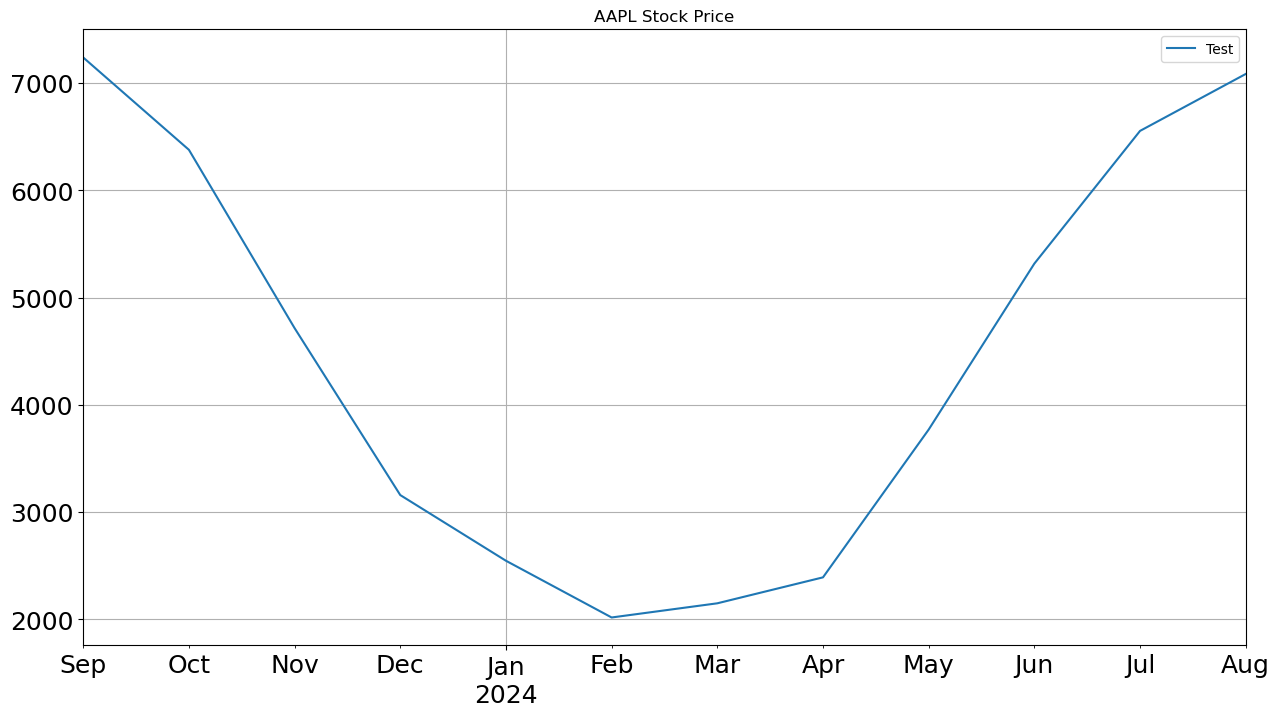

In [202]:
import matplotlib.pyplot as plt
# val_data['离职人数'].plot(figsize=(15,8), title= 'AAPL Stock Price', fontsize=18, label='Train')
preds.forecast['离职人数'].plot(figsize=(15,8), title= 'AAPL Stock Price', fontsize=18, label='Test')
# preds.lower_forecast['离职人数'].plot(figsize=(15,8), title= 'AAPL Stock Price', fontsize=18, label='lower')
# preds.upper_forecast['离职人数'].plot(figsize=(15,8), title= 'AAPL Stock Price', fontsize=18, label='upper')

plt.legend()
plt.grid()
plt.show()

In [ ]:
data["离职人数"].describe()

count       68.000000
mean      8640.191176
std       4688.698143
min       1502.000000
25%       5118.000000
50%       8158.000000
75%      10637.000000
max      23610.000000
Name: 离职人数, dtype: float64

## Prophet

In [491]:
from prophet import Prophet
# a_data = dimiistion_rate[dimiistion_rate["事业部"] == "A"]
# a_data.reset_index(inplace=True,drop=True)
# # a_data = a_data[a_data["年份"].isin([2018,2019])]
# data = a_data[["起始日期","离职率"]]
# data["起始日期"] = pd.to_datetime(data["起始日期"])
df = data.reset_index()
train_data = df[:-3]
val_data = df[-3:]
train_data.rename(columns={"起始日期": "ds", "离职率": "y"}, inplace=True)
# train_data["cap"] = 0.5
# train_data["floor"] = 0


In [492]:

m = Prophet()
m.add_country_holidays(country_name='CN')
# m.fit(df)
m.fit(train_data)
future = m.make_future_dataframe(periods=3,freq='M')
future.tail()

ds
63 2023-04-01
64 2023-05-01
65 2023-05-31
66 2023-06-30
67 2023-07-31

In [493]:
# future['cap'] = 0.5
# future["floor"] = 0
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)



ds      yhat  yhat_lower  yhat_upper
62 2023-03-01  0.183556    0.138620    0.229888
63 2023-04-01  0.172178    0.127807    0.215348
64 2023-05-01  0.216653    0.170609    0.260031
65 2023-05-31  0.135175    0.090641    0.180467
66 2023-06-30  0.169721    0.123550    0.212074
67 2023-07-31  0.241649    0.192458    0.290038

In [494]:
val_data

起始日期       离职率
65  2023-06-01  0.175243
66  2023-07-01  0.191788
67  2023-08-01  0.268953

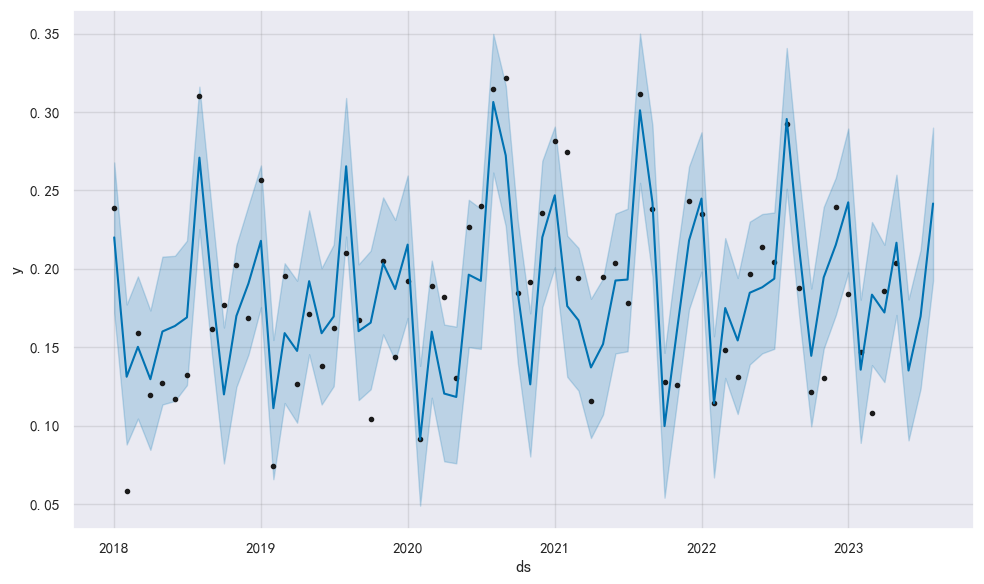

In [495]:
fig1 = m.plot(forecast)


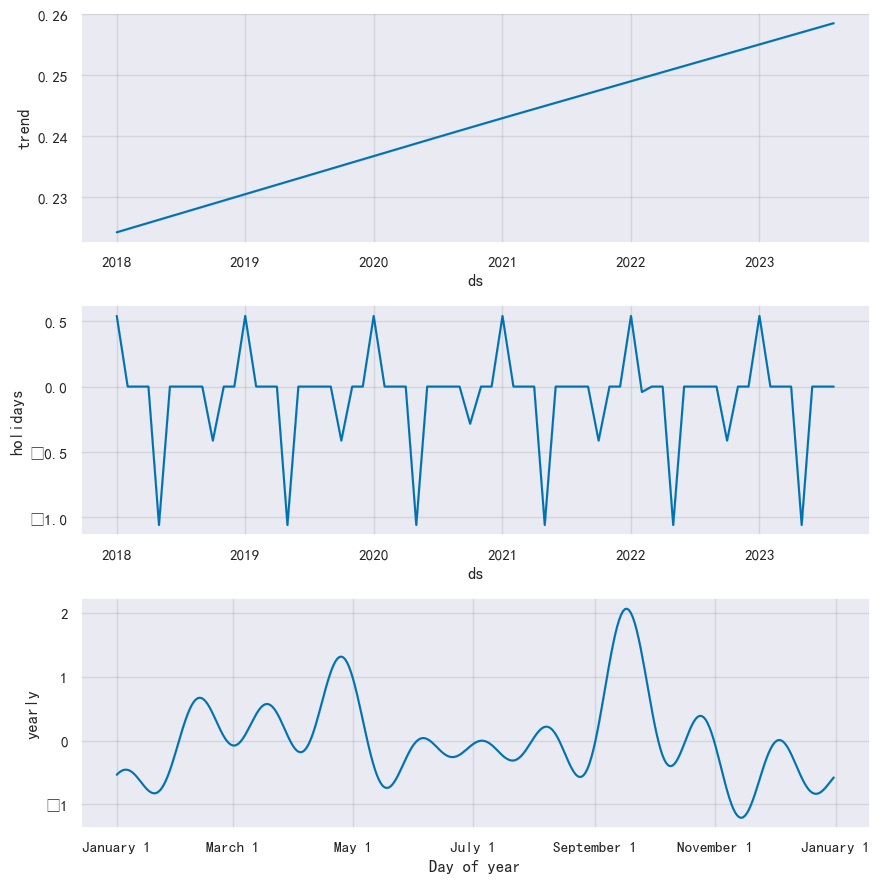

In [496]:
fig2 = m.plot_components(forecast)



In [497]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)


In [498]:
plot_components_plotly(m, forecast)
